# Help in optimizing HR management for business

## Project description

HR analysts at Work with Care help businesses optimize personnel management: the business provides data, and analysts suggest how to avoid financial losses and employee attrition. This is where HR analysts will benefit from machine learning, which will help them answer business questions faster and more accurately.

The company provided us with data containing the characteristics of the company's employees. Among them is the level of employee satisfaction with work in the company. This information was obtained from feedback forms: employees fill out a test questionnaire, and based on its results, the percentage of their satisfaction is calculated from 0 to 1, where 0 is completely dissatisfied, 1 is completely satisfied.

**Tasks**
- The first task is to build a model that can predict the level of employee satisfaction based on customer data.
Why is this important for business: Job satisfaction directly affects employee churn. And predicting churn is one of the most important tasks of HR analysts. Sudden layoffs carry risks for the company, especially if an important employee leaves.
- The second task is to build a model that can, based on customer data, predict that an employee will leave the company.

**Work plan:**

- Libraries and settings
- Task No. 1
   - Data loading
   - Data preprocessing
   - Exploratory data analysis
   - Correlation data analysis
   - Data preparation
   - Model training
   - Conclusions on the model
- Task No. 2
   - Data loading
   - Data preprocessing and adding an input feature
   - Exploratory data analysis
   - Correlation data analysis
   - Data preparation
   - Model training
   - Conclusions on the model
- Conclusions

**Description of data**

- `id` — unique identifier of the employee;
- `dept` — the department in which the employee works;
- `level` — level of the position held;
- `workload` — employee workload level;
- `employment_years` — duration of work in the company (in years);
- `last_year_promo` - shows whether there was a promotion in the last year;
- `last_year_violations` - shows whether the employee violated the employment contract over the last year;
- `supervisor_evaluation` — assessment of the quality of the employee’s work given by the manager;
- `salary` — monthly salary of the employee;
- `job_satisfaction_rate` — employee satisfaction level with work in the company, target attribute.

## Libraries and settings

Import libraries

In [1]:
%pip install shap
%pip install phik
%pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np
import warnings

from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")

## Objective 1: employee satisfaction

### Loading data

#### Files

In [4]:
try:
    train_job_satisfaction_rate = pd.read_csv('train_job_satisfaction_rate.csv')
    test_target_job_satisfaction_rate = pd.read_csv('test_target_job_satisfaction_rate.csv')
    test_features = pd.read_csv('test_features.csv')

except:
    train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

#### General information

In [5]:
train_job_satisfaction_rate.info()
display(train_job_satisfaction_rate.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


There are gaps in the `dept` and `level` columns.

In [6]:
test_target_job_satisfaction_rate.info()
display(test_target_job_satisfaction_rate.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [7]:
test_features.info()
display(test_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


There are gaps here again.

### Data preprocessing

#### Omissions

Check for gaps in each column

In [8]:
#train_job_satisfaction_rate file
print(f'Omissions in columns:\n{train_job_satisfaction_rate.isna().sum()}')

Omissions in columns:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [9]:
#test_features file
print(f'Omissions in columns:\n{test_features.isna().sum()}')

Omissions in columns:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [10]:
#test_target_job_satisfaction_rate file 
print(f'Omissions in columns:\n{test_target_job_satisfaction_rate.isna().sum()}')

Omissions in columns:
id                       0
job_satisfaction_rate    0
dtype: int64


There are gaps in the `dept` and `level` columns in the `train_job_satisfaction_rate` file. Also, in the `test_features` file there are gaps in the `dept` and `level` columns. We will fill them in the pipeline (later).

#### Changing column values

It is important to look at the unique values in the columns, as there may be implicit duplicates in the data due to typos

In [11]:
# train_job_satisfaction_rate file
for column in train_job_satisfaction_rate.select_dtypes(include=['object']).columns:
    print(f'Unique values in {column} column: {train_job_satisfaction_rate[column].unique()}')

Unique values in dept column: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Unique values in level column: ['junior' 'middle' 'sinior' nan]
Unique values in workload column: ['medium' 'high' 'low']
Unique values in last_year_promo column: ['no' 'yes']
Unique values in last_year_violations column: ['no' 'yes']


In [12]:
#test_features file
for column in test_features.select_dtypes(include=['object']).columns:
    print(f'Unique values in {column} column: {test_features[column].unique()}')

Unique values in dept column: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Unique values in level column: ['junior' 'middle' 'sinior' nan]
Unique values in workload column: ['medium' 'low' 'high' ' ']
Unique values in last_year_promo column: ['no' 'yes']
Unique values in last_year_violations column: ['no' 'yes']


There are gaps in the file in the form of empty lines. Let's change these values to `np.nan`

In [13]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)


# here we look at the values again
for column in test_features.select_dtypes(include=['object']).columns:
    print(f'Unique values in {column} column: {test_features[column].unique()}')


Unique values in dept column: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Unique values in level column: ['junior' 'middle' 'sinior' nan]
Unique values in workload column: ['medium' 'low' 'high' nan]
Unique values in last_year_promo column: ['no' 'yes']
Unique values in last_year_violations column: ['no' 'yes']


#### Duplicates

Consider the presence of complete duplicates in each dataframe

In [14]:
print(f'Duplicates in train_job_satisfaction_rate DataFrame: {train_job_satisfaction_rate.duplicated().sum()}')
print(f'Duplicates in test_features DataFrame: {test_features.duplicated().sum()}')
print(f'Duplicates in test_target_job_satisfaction_rate DataFrame: {test_target_job_satisfaction_rate.duplicated().sum()}')

Duplicates in train_job_satisfaction_rate DataFrame: 0
Duplicates in test_features DataFrame: 0
Duplicates in test_target_job_satisfaction_rate DataFrame: 0


There are no complete duplicates in the files.

#### Preprocessing results

**What we did:**
1. Checked for gaps in columns
2. Changed some empty lines to `np.nan`
3. Make sure there are no duplicates in the data


We didn't have to change the data types because they were correct from the start. Everything was fine with the column names as well.

### Exploratory data analysis

#### Functions

We create functions that will help us in the future when analyzing data

In [15]:
# Function for categorical analysis
def categorical_analysis(data, column, width=5, degree=0):
    print(data[column].value_counts())

    plt.figure(figsize=(width, 5))

    sns.countplot(x=column, data=data, palette="Set2", order=data[column].value_counts().index)
    plt.title(f'Value distribution in {column} column')
    plt.ylabel('Number of values')
    plt.xlabel('Category')
    plt.tick_params(axis='x', rotation=degree)
    plt.show()

# Function for numerical analysis
def numerical_analysis(data, column, bins=30, kde=True):
    print(data[column].describe())

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # Histogram
    ax[0] = sns.histplot(data[column], kde=kde, bins=bins, ax=ax[0])
    ax[0].set_title(f'Histogram for {column} column')
    ax[0].set_ylabel('Quantity')
    ax[0].set_xlabel('Value')

    # Boxplot
    ax[1] = sns.boxplot(data[column], ax=ax[1])
    ax[1].set_title(f'Boxplot for {column} column')
    ax[1].set_xlabel('Value')

    plt.show()

#### train_job_satisfaction_rate

dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64


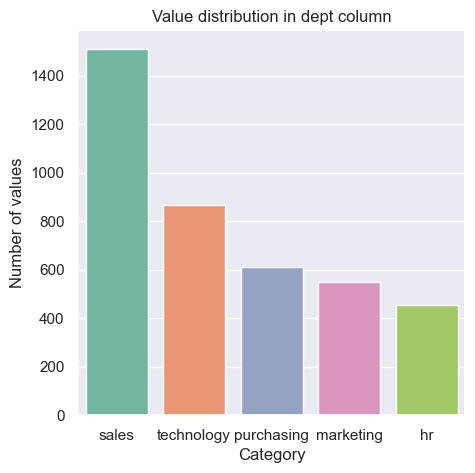

In [16]:
categorical_analysis(train_job_satisfaction_rate, 'dept')

Most clients work in the sales department, and the least in HR

level
junior    1894
middle    1744
sinior     358
Name: count, dtype: int64


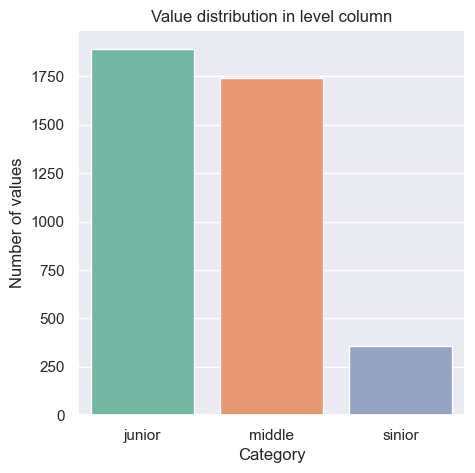

In [17]:
categorical_analysis(train_job_satisfaction_rate, 'level')

Oddly enough, there are the fewest employees at the senior level

workload
medium    2066
low       1200
high       734
Name: count, dtype: int64


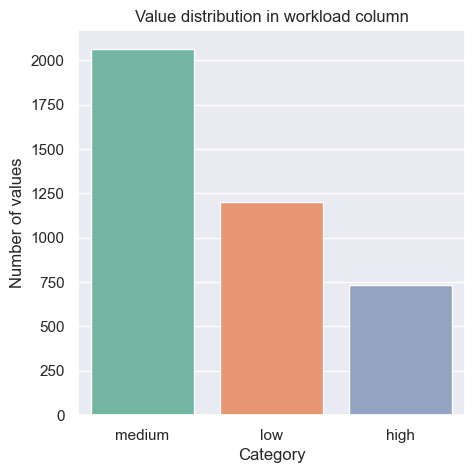

In [18]:
categorical_analysis(train_job_satisfaction_rate, 'workload')

Most employees have an average workload

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


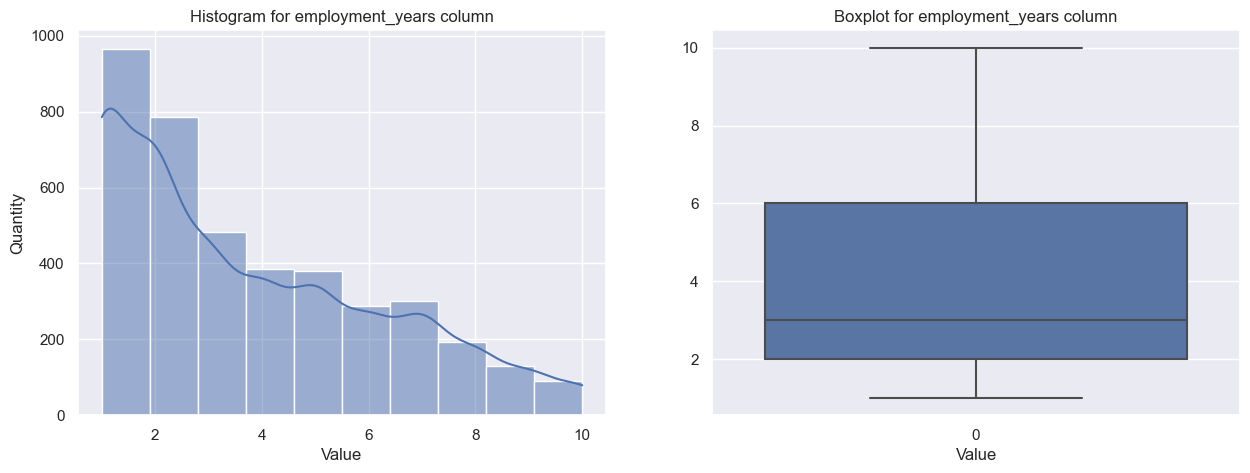

In [19]:
numerical_analysis(train_job_satisfaction_rate, 'employment_years', bins=10)

The company is dominated by new employees. The more years of work an employee has, the fewer there are

last_year_promo
no     3880
yes     120
Name: count, dtype: int64


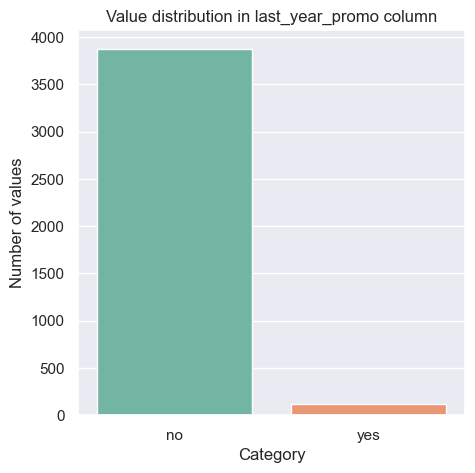

In [20]:
categorical_analysis(train_job_satisfaction_rate, 'last_year_promo')

A total of 120 employees were promoted over the past year

last_year_violations
no     3441
yes     559
Name: count, dtype: int64


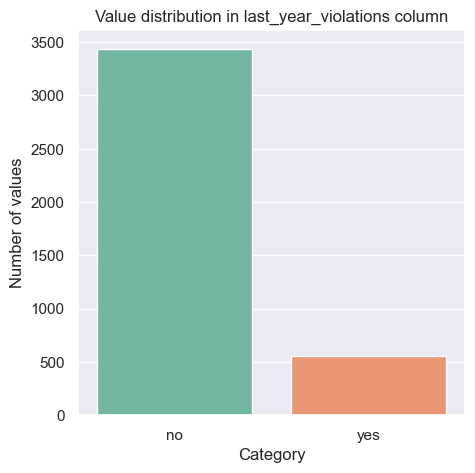

In [21]:
categorical_analysis(train_job_satisfaction_rate, 'last_year_violations')

559 company employees violated their employment contracts over the past year

supervisor_evaluation
4    1603
3    1263
5     546
2     387
1     201
Name: count, dtype: int64


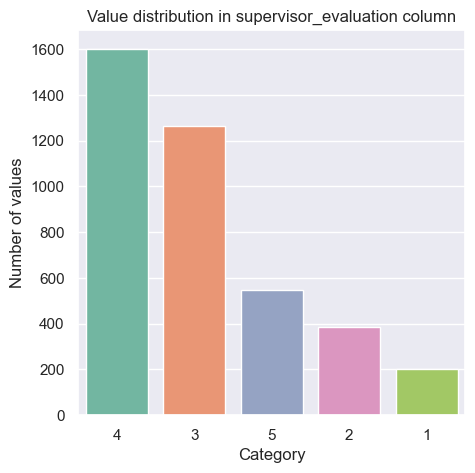

In [22]:
categorical_analysis(train_job_satisfaction_rate, 'supervisor_evaluation')

The majority of employees are rated 4 by their manager

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


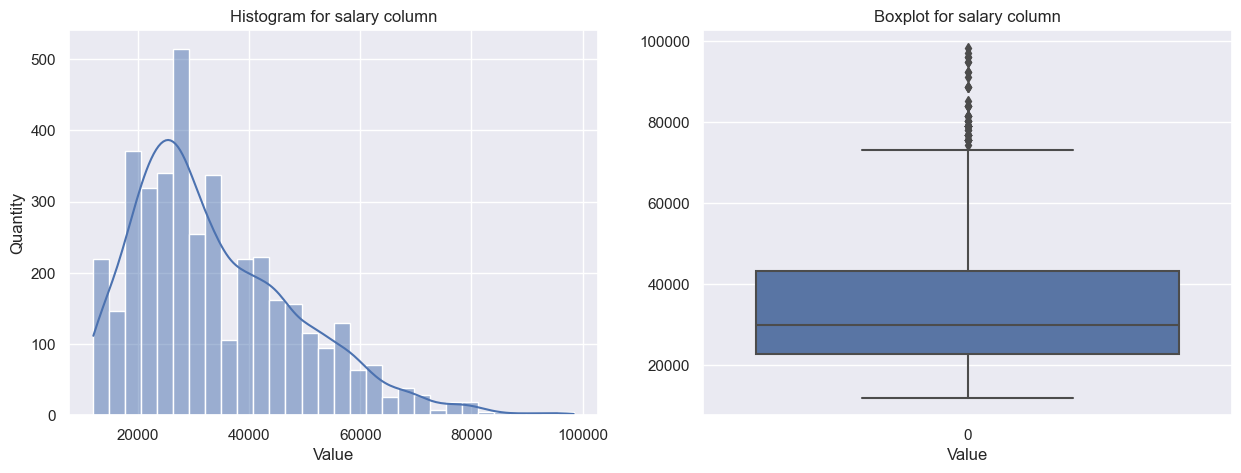

In [23]:
numerical_analysis(train_job_satisfaction_rate, 'salary')

Average employee salary: 33926. There are outliers in the data in the range of values from 75 thousand. Most likely, these are just very qualified employees, so we will not remove them (let’s look at the distribution of skill levels among such employees below)

level
sinior    59
Name: count, dtype: int64


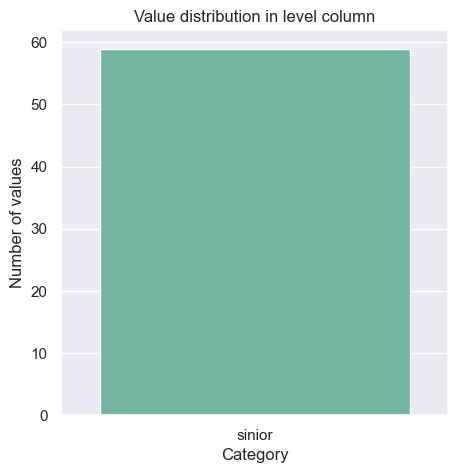

In [24]:
categorical_analysis(train_job_satisfaction_rate[train_job_satisfaction_rate['salary'] > 75000], 'level')

It's also interesting to see how busy they are.

workload
high    59
Name: count, dtype: int64


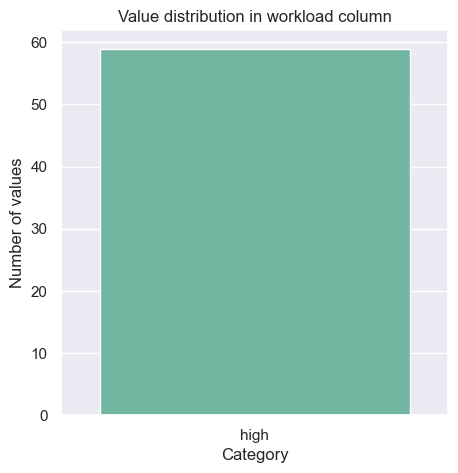

In [25]:
categorical_analysis(train_job_satisfaction_rate[train_job_satisfaction_rate['salary'] > 75000], 'workload')

Yes, the data is fine. Such values are not outliers

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


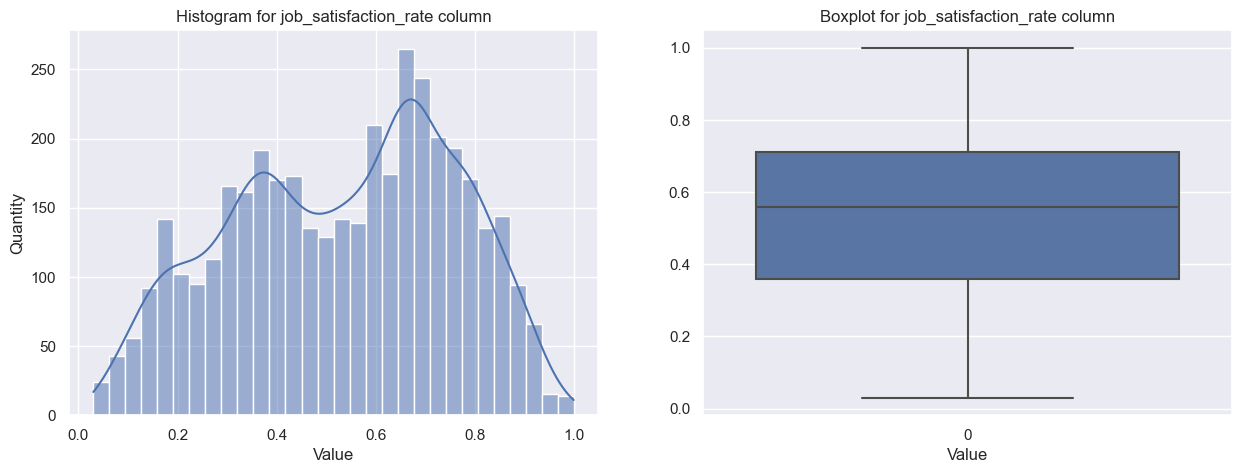

In [26]:
numerical_analysis(train_job_satisfaction_rate, 'job_satisfaction_rate')

The values are almost evenly distributed, so it is difficult to tell anything from them.

#### test_features

dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: count, dtype: int64


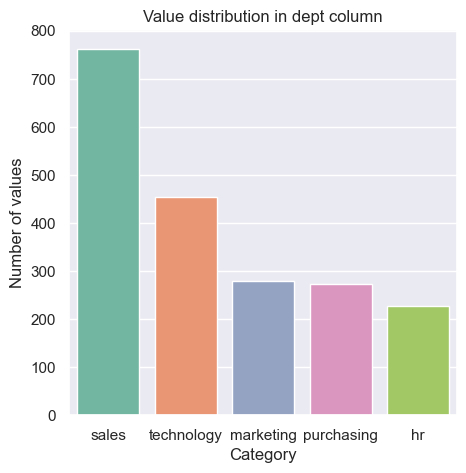

In [27]:
categorical_analysis(test_features, 'dept')

level
junior    974
middle    854
sinior    171
Name: count, dtype: int64


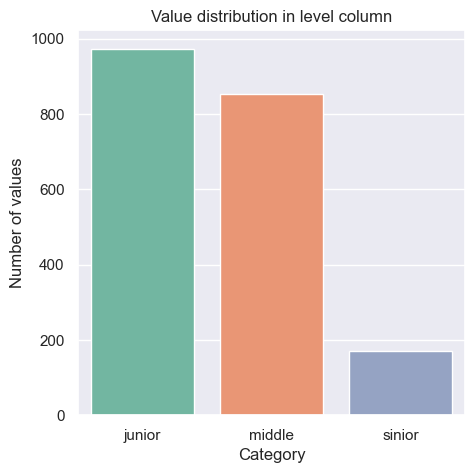

In [28]:
categorical_analysis(test_features, 'level')

workload
medium    1043
low        593
high       363
Name: count, dtype: int64


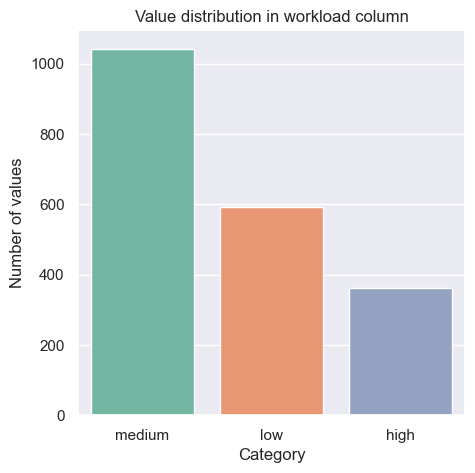

In [29]:
categorical_analysis(test_features, 'workload')

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


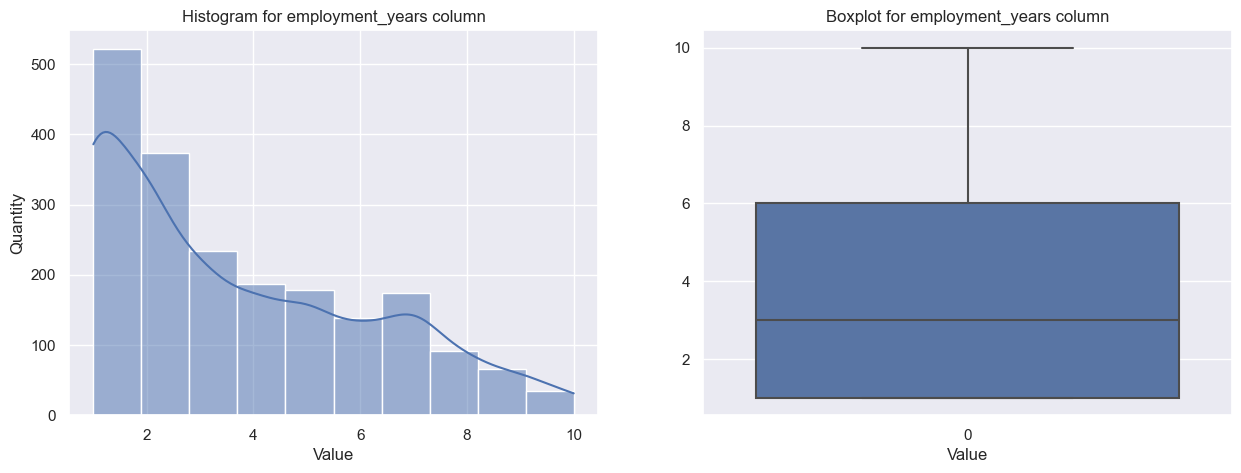

In [30]:
numerical_analysis(test_features, 'employment_years', bins=10)

last_year_promo
no     1937
yes      63
Name: count, dtype: int64


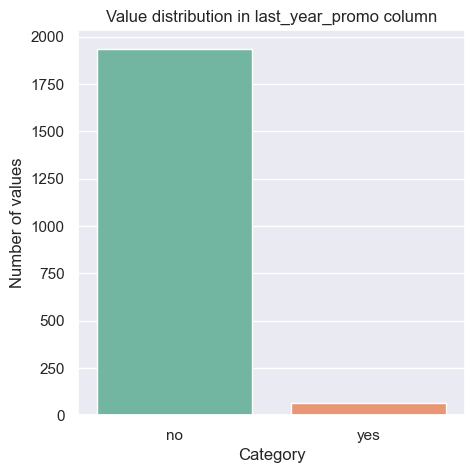

In [31]:
categorical_analysis(test_features, 'last_year_promo')

last_year_violations
no     1738
yes     262
Name: count, dtype: int64


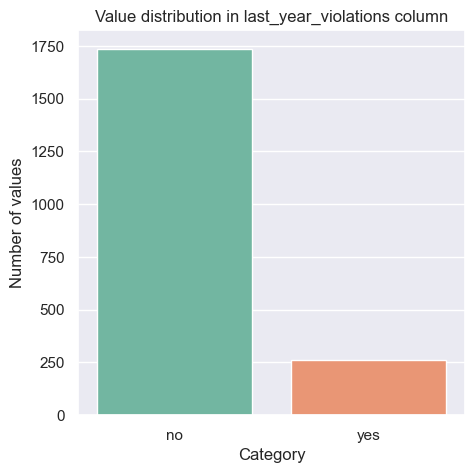

In [32]:
categorical_analysis(test_features, 'last_year_violations')

supervisor_evaluation
4    857
3    575
5    284
2    196
1     88
Name: count, dtype: int64


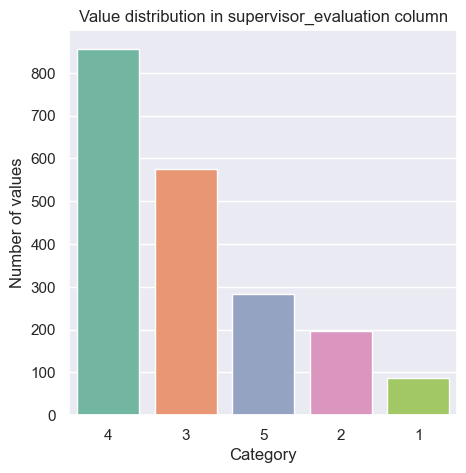

In [33]:
categorical_analysis(test_features, 'supervisor_evaluation')

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


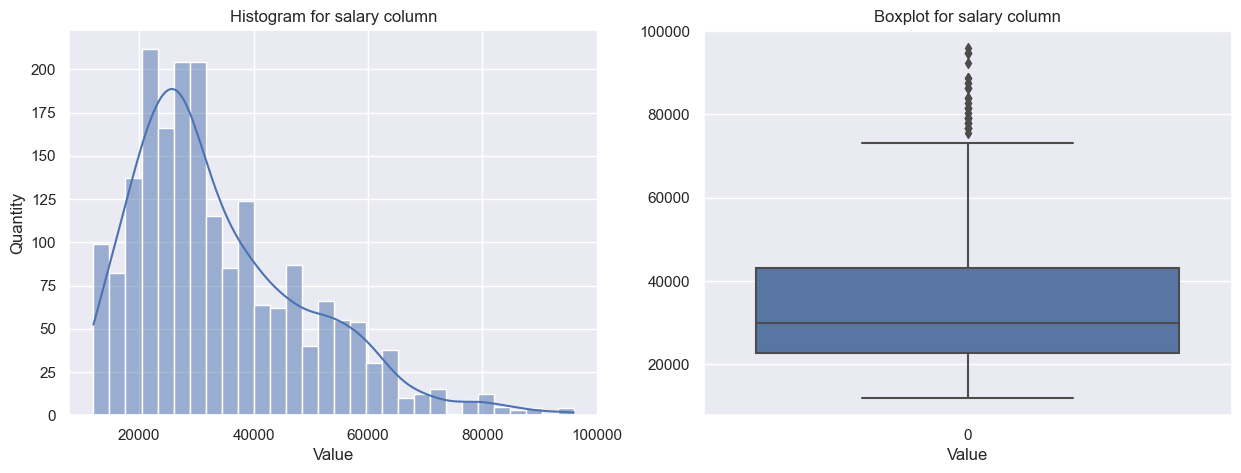

In [34]:
numerical_analysis(test_features, 'salary')

All this data is similar to the data from the `train_job_satisfaction_rate` file, so let's just move on

#### test_target_job_satisfaction_rate

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


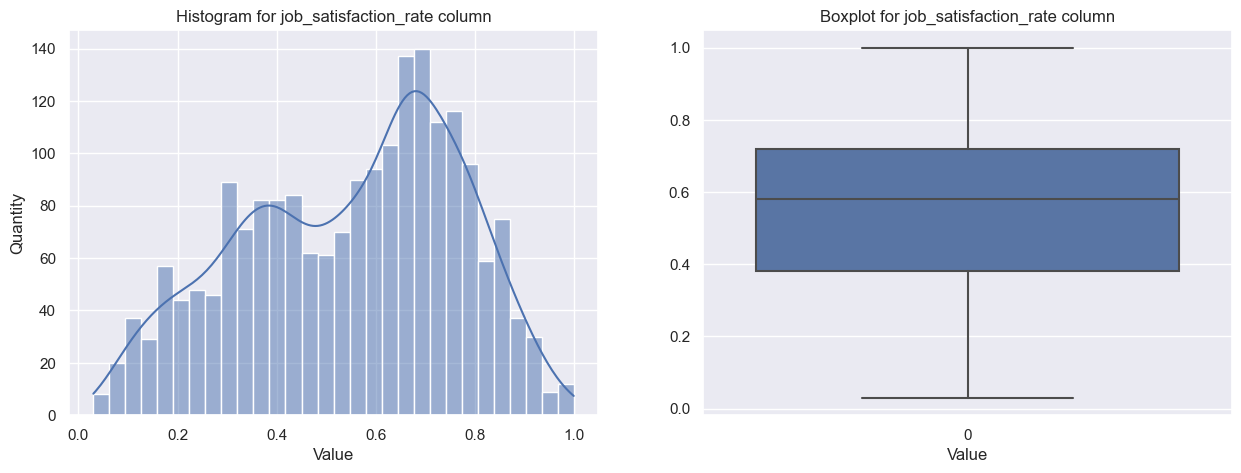

In [35]:
numerical_analysis(test_target_job_satisfaction_rate, 'job_satisfaction_rate')

Same here

#### Conclusions from the exploratory analysis

- Most employees work in the sales department, and the least in HR
- The share of employees with the `senior` qualification level is small
- The company has very few employees who have been promoted over the past year
- There are a small number of employees who violated their employment contracts
- The most common rating from a manager is 4
- Average employee salary - 33926
- The highest salaries are for `senior` employees with a high workload
- Average employee satisfaction - 0.5

### Correlation analysis

#### Матрица корреляций и графики

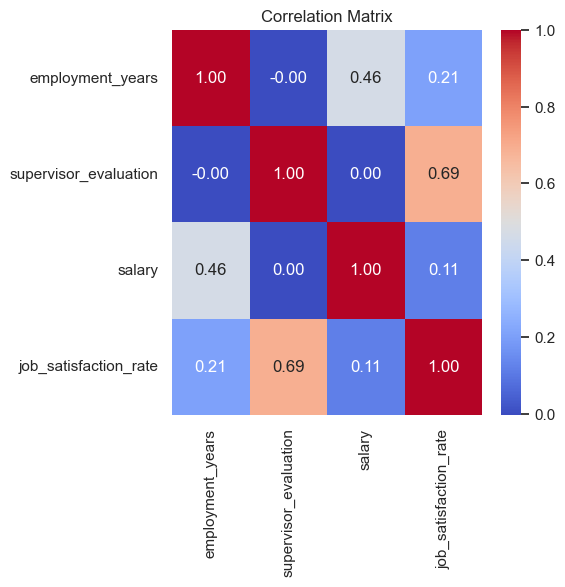

In [36]:
input_columns = train_job_satisfaction_rate.drop('id', axis=1).select_dtypes(exclude=['object']).columns.to_list()
correlation_matrix = train_job_satisfaction_rate[input_columns].corr() 

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Matrix')
plt.show()

Note that there is a weak correlation between `salary` and `employment_years`. There is also a strong correlation between manager evaluation and employee satisfaction. Let's look at this data using separate graphs

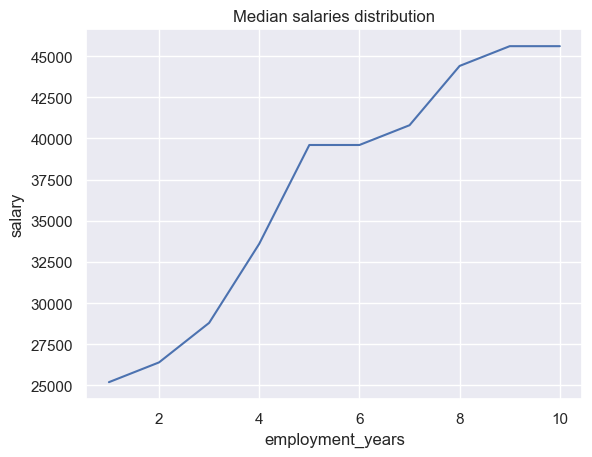

In [37]:
pivot = pd.pivot_table(data=train_job_satisfaction_rate, index='employment_years', values=['salary'], aggfunc='median')
sns.lineplot(x=pivot.index, y=pivot['salary'], data=pivot)
plt.title('Median salaries distribution')
plt.show()

Median salaries increase as an employee's length of service increases.

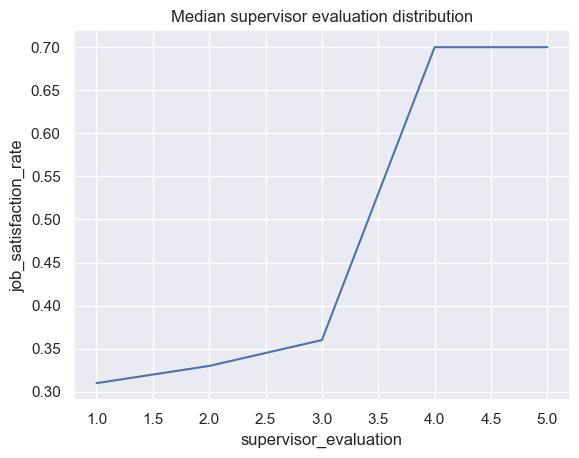

In [38]:
pivot = pd.pivot_table(data=train_job_satisfaction_rate, index='supervisor_evaluation', values=['job_satisfaction_rate'], aggfunc='median')
sns.lineplot(x=pivot.index, y=pivot['job_satisfaction_rate'], data=pivot)
plt.title('Median supervisor evaluation distribution')
plt.show()

The median actually rises as the leader's rating increases.

Let's look at the correlation matrix using the `phik` library

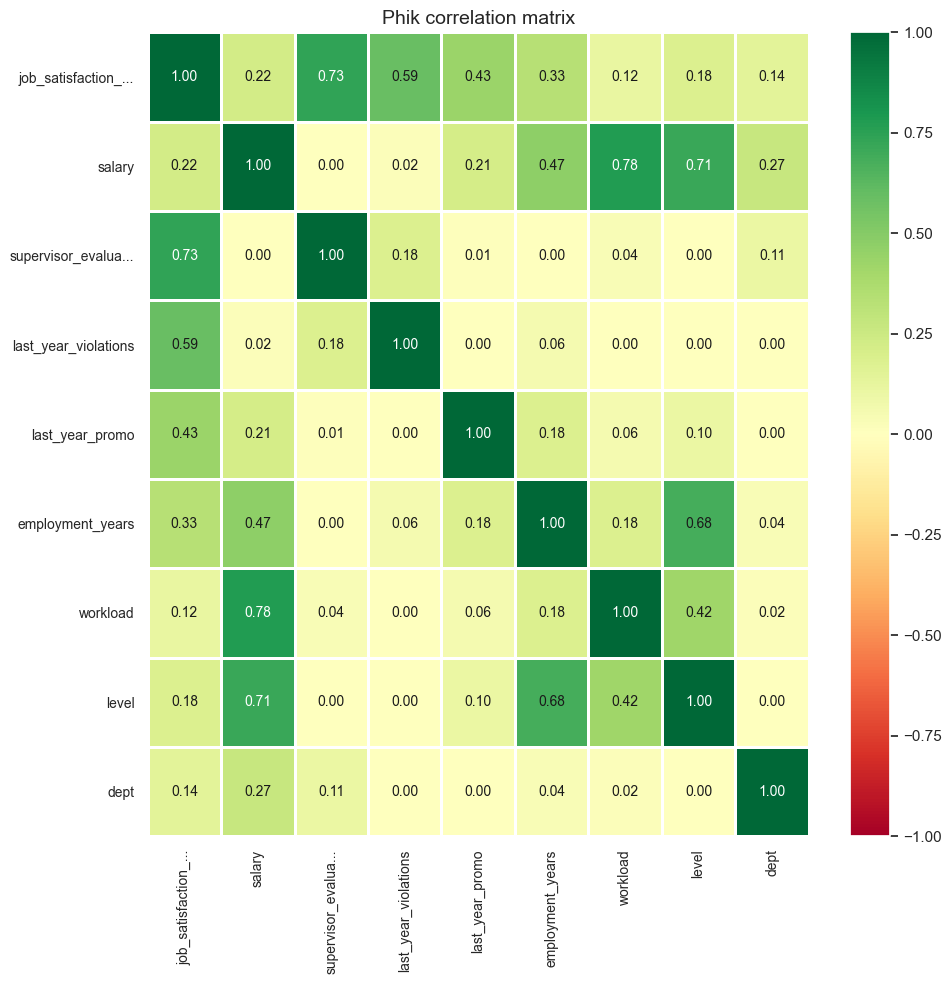

In [39]:
interval_cols = ['supervisor_evaluation', 'salary', 'employment_years']

phik_overview = train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    title='Phik correlation matrix',
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(10, 10)
) 


There is a strong correlation here between `level` and `salary`; `workload` and `salary`; `level` and `employment_years`, which is quite logical. Again, there is a strong correlation between `job_satisfaction_rate` and `supervisor_evaluatoion`. And it is interesting to note that there is also a strong `job_satisfaction_rate` and `last_year_violations`.

#### Conclusions

- As work experience increases, the median salary increases
- With an increase in management ratings, the median employee satisfaction increases
- There is a correlation between `job_satisfaction_rate` and `last_year_violations`; `job_satisfaction_rate` and `supervisor_evaluatoion`
- There are also logical dependencies between skill level and salary; workload and salary; work experience and skill level

All these dependencies are not too strong to greatly affect the performance of the model, so we can move on.

### Data preparation

For convenience, let’s convert the values of the target characteristic into percentages (multiply the value by 100)

In [40]:
train_job_satisfaction_rate['job_satisfaction_rate'] = train_job_satisfaction_rate['job_satisfaction_rate'] * 100
train_job_satisfaction_rate['job_satisfaction_rate'] = train_job_satisfaction_rate['job_satisfaction_rate'].astype('int64')
test_target_job_satisfaction_rate['job_satisfaction_rate'] = test_target_job_satisfaction_rate['job_satisfaction_rate'] * 100
test_target_job_satisfaction_rate['job_satisfaction_rate'] = test_target_job_satisfaction_rate['job_satisfaction_rate'].astype('int64')

In [41]:
RANDOM_STATE = 42
target_column = 'job_satisfaction_rate'

train_job_satisfaction_rate.set_index('id', inplace=True)
test_features.set_index('id', inplace=True)
test_target_job_satisfaction_rate.set_index('id', inplace=True)

See if duplicates have appeared and delete them if there are any.

In [42]:
print("Omissions in train-file before preprocessing:", train_job_satisfaction_rate.duplicated().sum())
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
print("Omissions in train-file after preprocessing:", train_job_satisfaction_rate.duplicated().sum())


Omissions in train-file before preprocessing: 258
Omissions in train-file after preprocessing: 0


In [43]:
ord_columns = ['level', 'workload']
ohe_columns = train_job_satisfaction_rate.drop([target_column, 'level', 'workload'], axis=1).select_dtypes(include=['object']).columns.to_list()
num_columns = train_job_satisfaction_rate.drop(target_column, axis=1).select_dtypes(exclude=['object']).columns.to_list()

test_data = pd.merge(test_features, test_target_job_satisfaction_rate, on='id')

In [44]:
X_train = train_job_satisfaction_rate.drop(target_column, axis=1)
y_train = train_job_satisfaction_rate[target_column]
X_test = test_data.drop(target_column, axis=1)
y_test = test_data[target_column]

Create a pipeline for data preparation

In [45]:
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
])

In [46]:
ord_pipe = Pipeline([
    ('SimpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high']
            ],
        handle_unknown='use_encoded_value', unknown_value=np.nan), 
        ),
    ('SimpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))

])


data_preprocessor = ColumnTransformer(
    [   
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Models

Since we are solving a regression problem, we will try to take two models: `DecisionTreeRegressor` and one linear model. We will choose the best one using the new `SMAPE` metric

#### Metric

We will evaluate the model using the `SMAPE` metric (“symmetric mean absolute percentage deviation”)

In [47]:
def calculate_smape(target, prediction):
    target = np.ravel(target)
    prediction = np.ravel(prediction)
    return 1 / len(target) * sum( abs(target - prediction) / ( (abs(target) + abs(prediction)) * 0.5) ) * 100

smape = make_scorer(calculate_smape, greater_is_better=False)

#### DecisionTreeRegressor

In [48]:
pipe_decision_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [49]:
# Parameters grid for DecisionTreeClassifier()
params_for_tree = {
    'models__max_depth': (None, *range(2, 7)),
    'models__min_samples_split': range(3, 7),
    'models__min_samples_leaf': range(2, 5),
    'models__max_features': range(2, 10),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

In [50]:
randomized_search_dt = RandomizedSearchCV(
    pipe_decision_tree, 
    params_for_tree, 
    cv=5,
    scoring=smape,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


randomized_search_dt.fit(X_train, y_train)

print(f"Best model and it's parameters:\n{randomized_search_dt.best_estimator_}")
print("Best model's score on cross-validation:", -randomized_search_dt.best_score_)

Best model and it's parameters:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('SimpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                 

In [51]:
print(randomized_search_dt.best_params_)

{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 4, 'models__max_features': 8, 'models__max_depth': None}


#### Linear model

In [52]:
pipe_linear = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [53]:
smape = cross_val_score(pipe_linear, X_train, y_train, scoring=smape).mean() * -1
print(f"Model's score on cross-validation: {smape}")

Model's score on cross-validation: 25.025543313863956


Note that the `DeicionTreeRegressor` model has the best metric of those considered, so let's try to take it and see how the model behaves on the test sample

In [54]:
preprocessor_dt = randomized_search_dt.best_estimator_.named_steps['preprocessor']
best_model_dt = randomized_search_dt.best_estimator_.named_steps['models']

y_pred = randomized_search_dt.best_estimator_.predict(X_test)
smape_test = calculate_smape(y_test, y_pred)

print(f'SMAPE metric value on test-data: {smape_test}')

SMAPE metric value on test-data: 13.939062617031539


The `SMAPE` metric on the test sample is `13.9`, which fits our criterion for selecting a model. We will use exactly this model. Just in case, let's compare the metrics of our model with the constant model to make sure that the model really performs its task

In [55]:
X_train_scalled = data_preprocessor.fit_transform(X_train)
X_test_scalled = data_preprocessor.transform(X_test)

dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)

predictions_dummy = dummy.predict(X_test)
calculate_smape(y_test, predictions_dummy)

37.745573906268866

Yes, our model really does its job.

#### Conclusions

- The `DecisionTreeRegressor` model performed better in the regression task for this data set.
- For the `DecisionTreeRegressor` model, the metric `SMAPE` = 14% means that the predicted values differ from the actual values by an average of 14%, which is a good result for this task.
- The `LinearRegression` model has too high a percentage difference between the actual values and the predicted ones, perhaps it is too simple a model for our task.

So, in this case, the DecisionTreeRegressor model is better suited to solve the problem of predicting the level of employee satisfaction.

## Objective 2: layoffs of employees

### Loading data

#### Files

In [56]:
try:
    train_quit = pd.read_csv('train_quit')
    test_target_quit = pd.read_csv('test_target_quit')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

#### General information

In [57]:
train_quit.info()
display(train_quit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [58]:
test_target_quit.info()
display(test_target_quit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


It is difficult to say anything based on the data in advance.

### Data preprocessing

#### Adding predictions

Add predictions to new files using the best model obtained earlier

In [59]:
ohe_feature_names = preprocessor_dt.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(input_features=ohe_columns)
ord_feature_names = preprocessor_dt.named_transformers_['ord'].named_steps['ord'].get_feature_names_out(input_features=ord_columns)
num_feature_names = num_columns
names = np.concatenate([ohe_feature_names, num_feature_names, ord_feature_names])


train_quit_preprocessed = pd.DataFrame(preprocessor_dt.transform(train_quit), columns=names)
train_quit['job_satisfaction_predict'] = best_model_dt.predict(train_quit_preprocessed)

test_features_preprocessed = pd.DataFrame(preprocessor_dt.transform(test_features), columns=names)
test_features['job_satisfaction_predict'] = best_model_dt.predict(test_features_preprocessed)

In [60]:
display(train_quit)
train_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_predict
0,723290,sales,middle,high,2,no,no,4,54000,no,61.750000
1,814010,sales,junior,medium,2,no,no,4,27600,no,84.636364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,33.250000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,27.714286
4,910140,marketing,junior,medium,2,no,no,5,25200,no,80.200000
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,51.600000
3996,672059,sales,middle,high,9,no,no,4,52800,no,83.600000
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,53.857143
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,49.363636


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        4000 non-null   int64  
 1   dept                      4000 non-null   object 
 2   level                     4000 non-null   object 
 3   workload                  4000 non-null   object 
 4   employment_years          4000 non-null   int64  
 5   last_year_promo           4000 non-null   object 
 6   last_year_violations      4000 non-null   object 
 7   supervisor_evaluation     4000 non-null   int64  
 8   salary                    4000 non-null   int64  
 9   quit                      4000 non-null   object 
 10  job_satisfaction_predict  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB


In [61]:
display(test_features)
test_features.info()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_predict
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,88.500000
686555,hr,junior,medium,1,no,no,4,30000,67.875000
467458,sales,middle,low,5,no,no,4,19200,64.333333
418655,sales,middle,low,6,no,no,4,19200,66.600000
789145,hr,middle,medium,5,no,no,5,40800,82.600000
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,53.714286
109582,technology,middle,low,3,no,no,2,21600,15.200000
305653,technology,junior,low,1,no,no,3,14400,20.250000


<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dept                      1997 non-null   object 
 1   level                     1999 non-null   object 
 2   workload                  1999 non-null   object 
 3   employment_years          2000 non-null   int64  
 4   last_year_promo           2000 non-null   object 
 5   last_year_violations      2000 non-null   object 
 6   supervisor_evaluation     2000 non-null   int64  
 7   salary                    2000 non-null   int64  
 8   job_satisfaction_predict  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


#### Omissions

In [62]:
#train_quit file
print(f'Omissions in columns:\n{train_quit.isna().sum()}')

Omissions in columns:
id                          0
dept                        0
level                       0
workload                    0
employment_years            0
last_year_promo             0
last_year_violations        0
supervisor_evaluation       0
salary                      0
quit                        0
job_satisfaction_predict    0
dtype: int64


In [63]:
#test_target_quit file 
print(f'Omissions in columns:\n{test_target_quit.isna().sum()}')

Omissions in columns:
id      0
quit    0
dtype: int64


There are no omissions in the data.

#### Changing column values

You need to check if there are any errors in the values

In [64]:
#train_job_satisfaction_rate file
for column in train_quit.select_dtypes(include=['object']).columns:
    print(f'Unique values in {column} column: {train_quit[column].unique()}')

Unique values in dept column: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Unique values in level column: ['middle' 'junior' 'sinior']
Unique values in workload column: ['high' 'medium' 'low']
Unique values in last_year_promo column: ['no' 'yes']
Unique values in last_year_violations column: ['no' 'yes']
Unique values in quit column: ['no' 'yes']


The data is fine.

In [65]:
#test_target_quit file
for column in test_target_quit.select_dtypes(include=['object']).columns:
    print(f'Unique values in {column} colunmn: {test_target_quit[column].unique()}')

Unique values in quit colunmn: ['yes' 'no']


Here too.

#### Duplicates

Look at the presence of complete duplicates in the files

In [66]:
print(f'Duplicates in train_job_satisfaction_rate DataFrame: {train_quit.duplicated().sum()}')
print(f'Duplicates in test_target_job_satisfaction_rate DataFrame: {test_target_quit.duplicated().sum()}')

Duplicates in train_job_satisfaction_rate DataFrame: 0
Duplicates in test_target_job_satisfaction_rate DataFrame: 0


There are no duplicates in the data.

#### Preprocessing results

**What we found out:**
1. There are no gaps in the data
2. There are no duplicates in the data
3. There are no typos among the values
4. All data types are correct


We also added predictions using the previously obtained model

### Exploratory data analysis

#### train_quit

dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64


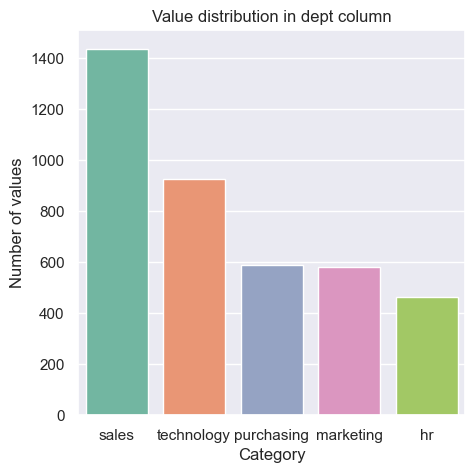

In [67]:
categorical_analysis(train_quit, 'dept')

Most employees work in the sales department

level
junior    1949
middle    1694
sinior     357
Name: count, dtype: int64


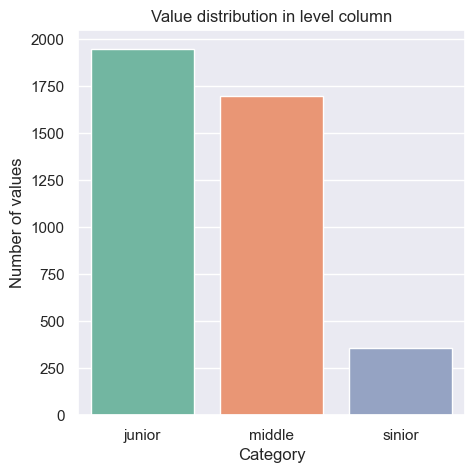

In [68]:
categorical_analysis(train_quit, 'level')

Total 357 employees with `senior` level

workload
medium    2118
low       1208
high       674
Name: count, dtype: int64


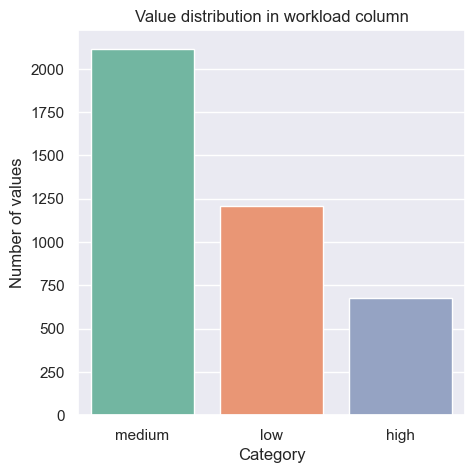

In [69]:
categorical_analysis(train_quit, 'workload')

Most employees have an average workload

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


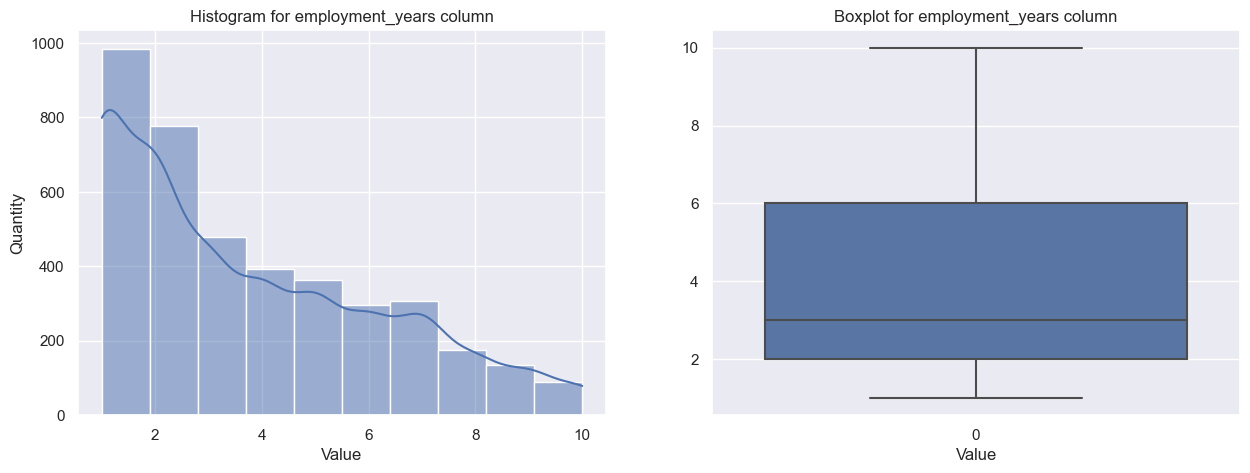

In [70]:
numerical_analysis(train_quit, 'employment_years', bins=10)

The company is dominated by new employees (up to 3 years of work)

last_year_promo
no     3887
yes     113
Name: count, dtype: int64


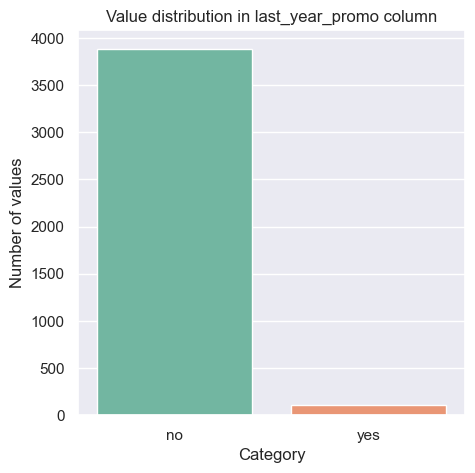

In [71]:
categorical_analysis(train_quit, 'last_year_promo')

Only 113 employees managed to get promoted

last_year_violations
no     3455
yes     545
Name: count, dtype: int64


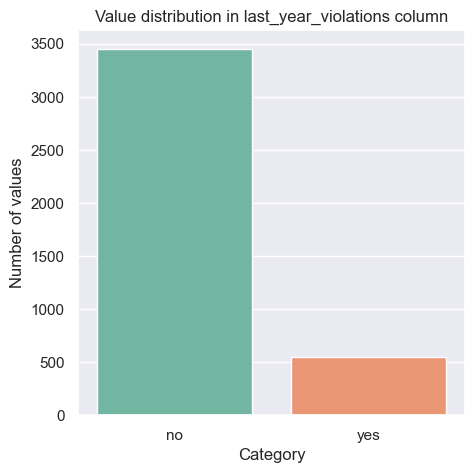

In [72]:
categorical_analysis(train_quit, 'last_year_violations')

Almost 545 employees violated their employment contracts

supervisor_evaluation
4    1654
3    1233
5     520
2     391
1     202
Name: count, dtype: int64


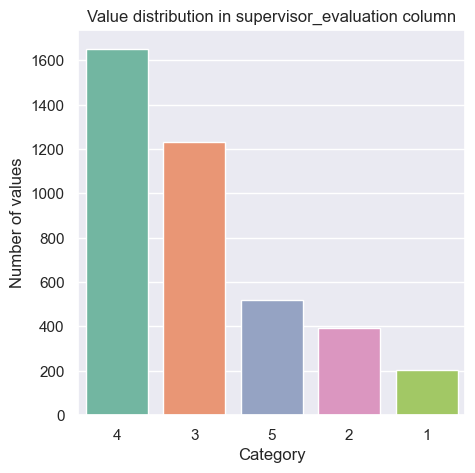

In [73]:
categorical_analysis(train_quit, 'supervisor_evaluation')

Most employees are rated 4 by their manager

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


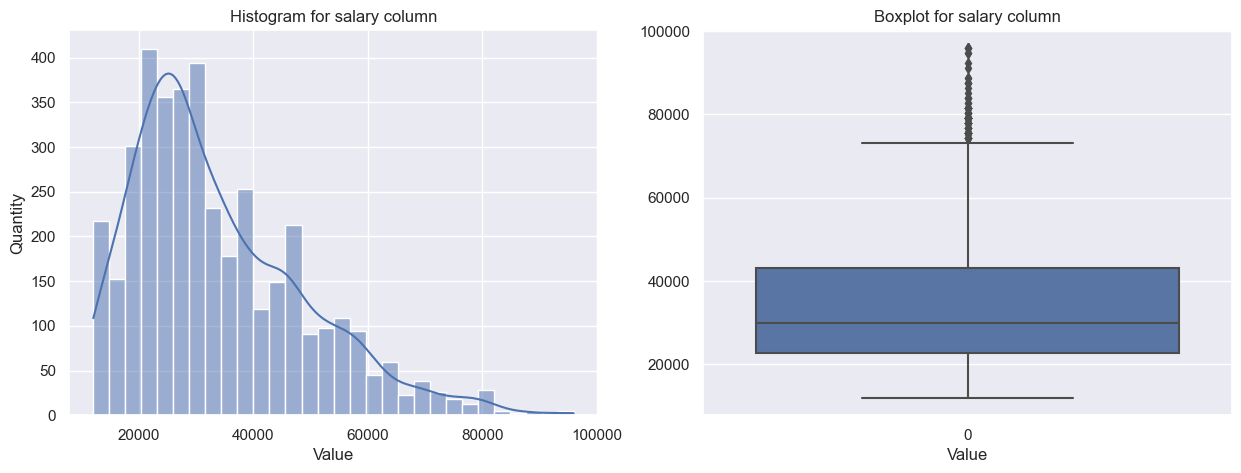

In [74]:
numerical_analysis(train_quit, 'salary')

Average salary - 33805

Let's look at the happy owners of large salaries

level
sinior    72
Name: count, dtype: int64


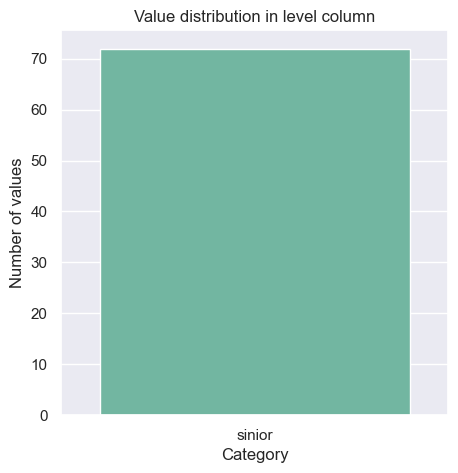

In [75]:
categorical_analysis(train_quit[train_quit['salary'] > 75000], 'level')

workload
high    72
Name: count, dtype: int64


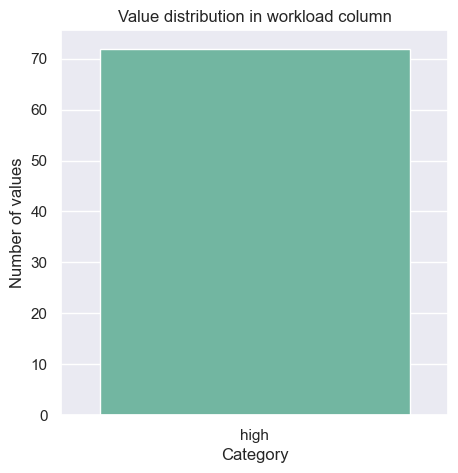

In [76]:
categorical_analysis(train_quit[train_quit['salary'] > 75000], 'workload')

The highest salaries are for `senior` workers with a high workload, which is logical

quit
no     2872
yes    1128
Name: count, dtype: int64


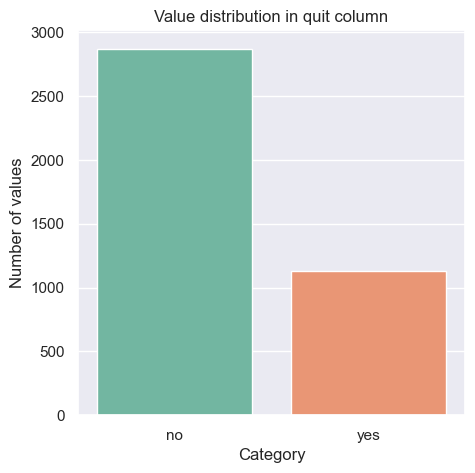

In [77]:
categorical_analysis(train_quit, 'quit')

Almost 40% of employees left the company

count    4000.000000
mean       53.866225
std        21.665757
min         6.000000
25%        35.000000
50%        54.000000
75%        68.800000
max        98.250000
Name: job_satisfaction_predict, dtype: float64


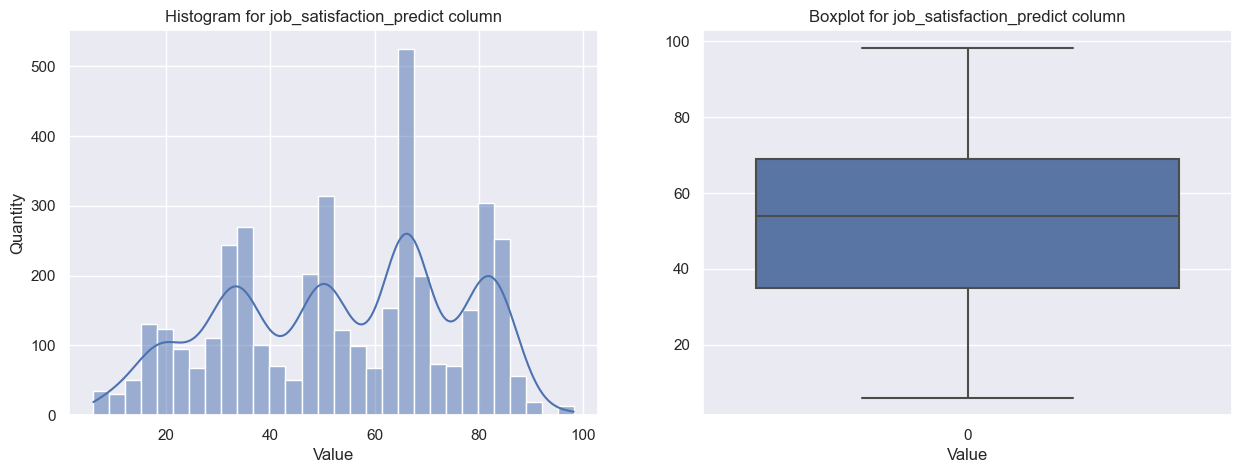

In [78]:
numerical_analysis(train_quit, 'job_satisfaction_predict')

#### test_target_quit

quit
no     1436
yes     564
Name: count, dtype: int64


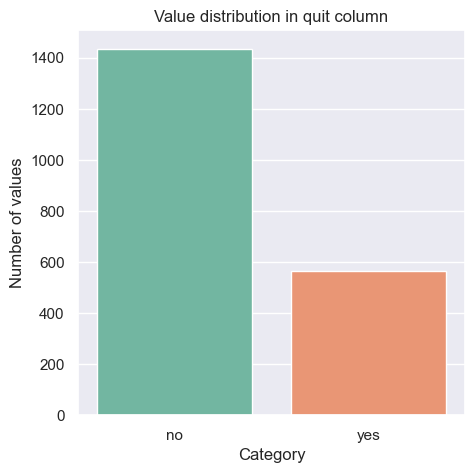

In [79]:
categorical_analysis(test_target_quit, 'quit')

#### Portrait of a “resigned employee”

Let's consider everything given for individual employees who quit in order to create their “portrait”

dept
sales         407
technology    276
purchasing    166
marketing     163
hr            116
Name: count, dtype: int64


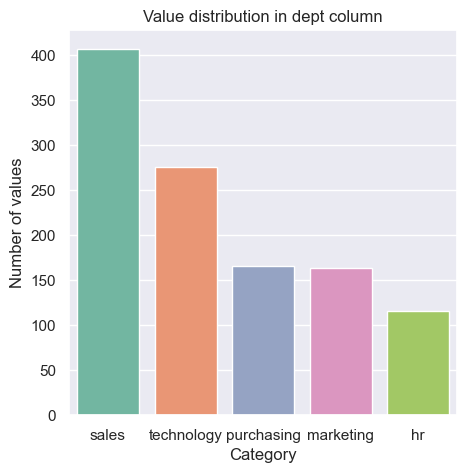

In [80]:
categorical_analysis(train_quit[train_quit['quit'] == 'yes'].reset_index(), 'dept')

Most work in the sales department.

level
junior    1003
middle     108
sinior      17
Name: count, dtype: int64


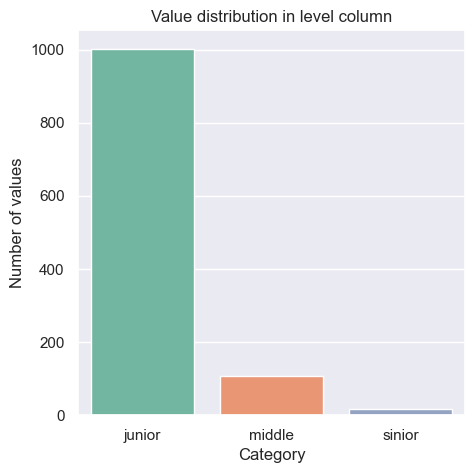

In [81]:
categorical_analysis(train_quit[train_quit['quit'] == 'yes'].reset_index(), 'level')

It seems that among the employees who left, those whose qualification level is `junior` predominate

workload
low       519
medium    488
high      121
Name: count, dtype: int64


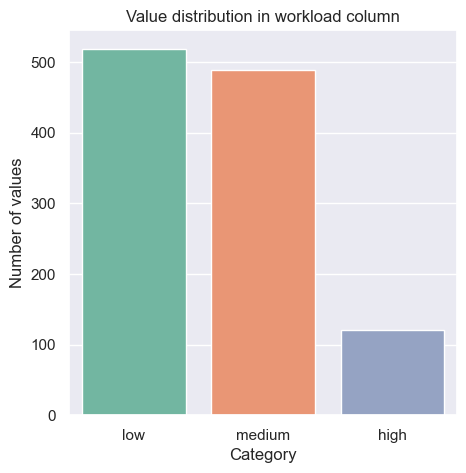

In [82]:
categorical_analysis(train_quit[train_quit['quit'] == 'yes'].reset_index(), 'workload')

The majority of employees here are low-employment, but almost the same number are medium-employment.

count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64


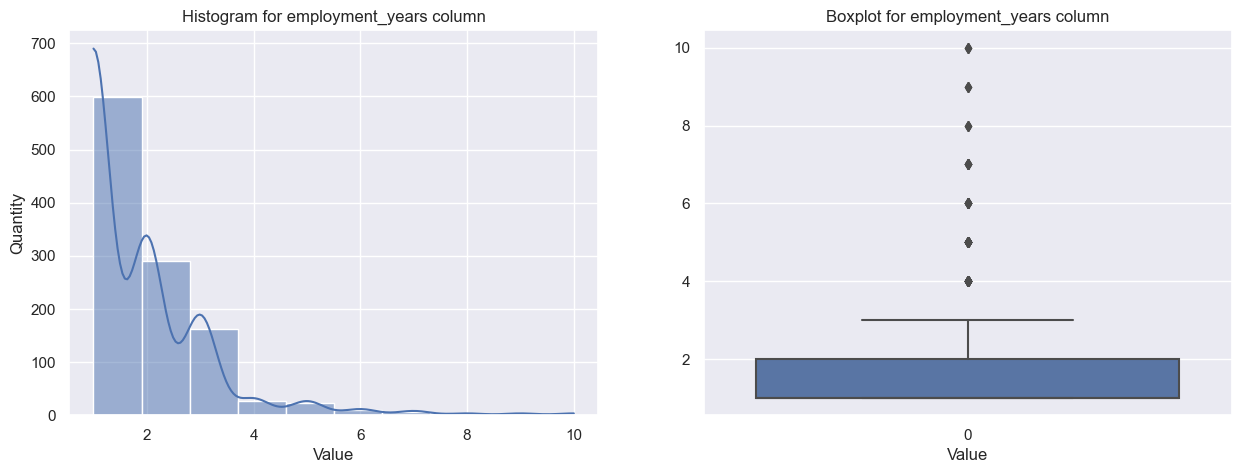

In [83]:
numerical_analysis(train_quit[train_quit['quit'] == 'yes'].reset_index(), 'employment_years', bins=10)

More than 50 percent of all values are 1. It turns out that newcomers predominate among employees who quit

last_year_promo
no     1127
yes       1
Name: count, dtype: int64


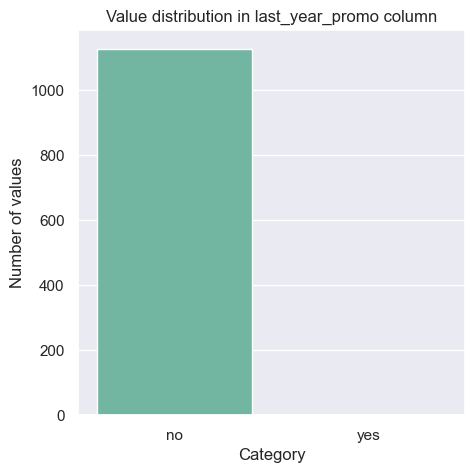

In [84]:
categorical_analysis(train_quit[train_quit['quit'] == 'yes'].reset_index(), 'last_year_promo')

Only one employee who received a promotion decided to quit

last_year_violations
no     900
yes    228
Name: count, dtype: int64


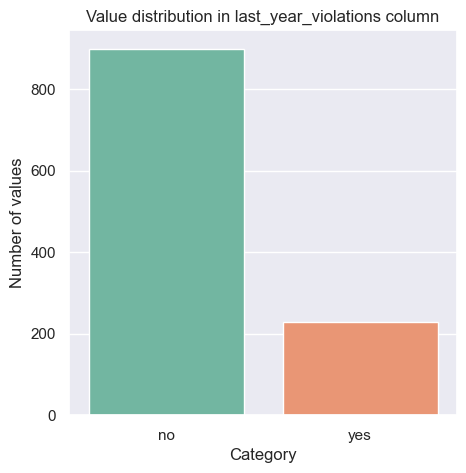

In [85]:
categorical_analysis(train_quit[train_quit['quit'] == 'yes'].reset_index(), 'last_year_violations')

Here the data is similar to the general ones

supervisor_evaluation
3    523
4    286
2    164
1     95
5     60
Name: count, dtype: int64


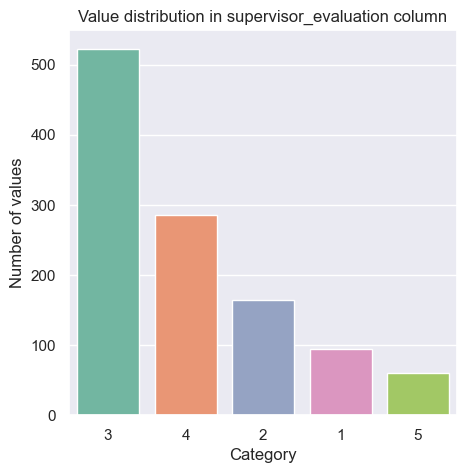

In [86]:
categorical_analysis(train_quit[train_quit['quit'] == 'yes'].reset_index(), 'supervisor_evaluation')

The most common rating among such employees is 3

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64


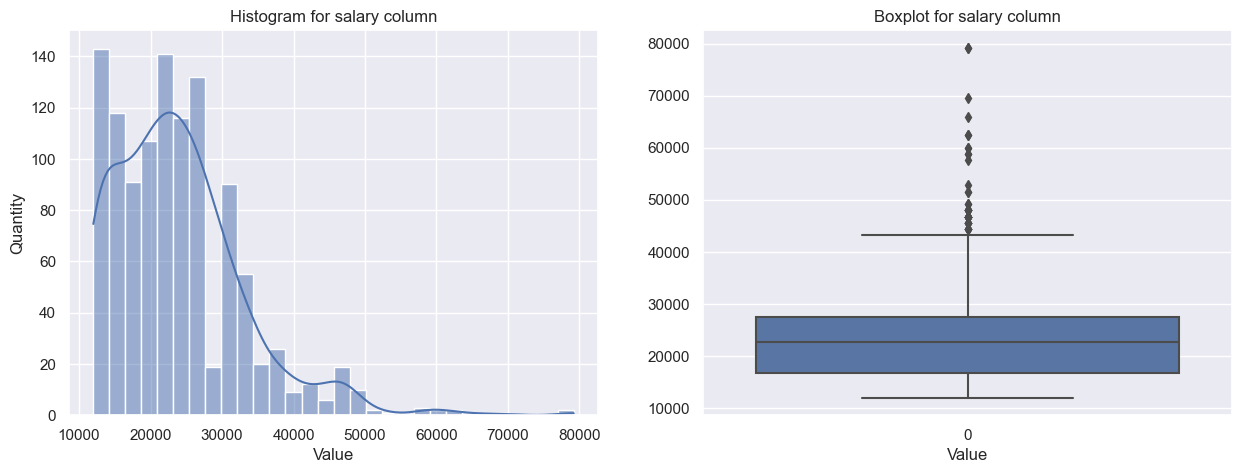

In [87]:
numerical_analysis(train_quit[train_quit['quit'] == 'yes'].reset_index(), 'salary')

Note that the majority of employees who quit have low salaries - the average among dismissed employees is 23,000, while among all - 33,000

count    1128.000000
mean       40.004628
std        18.714808
min         6.000000
25%        26.400000
50%        35.571429
75%        51.723214
max        89.400000
Name: job_satisfaction_predict, dtype: float64


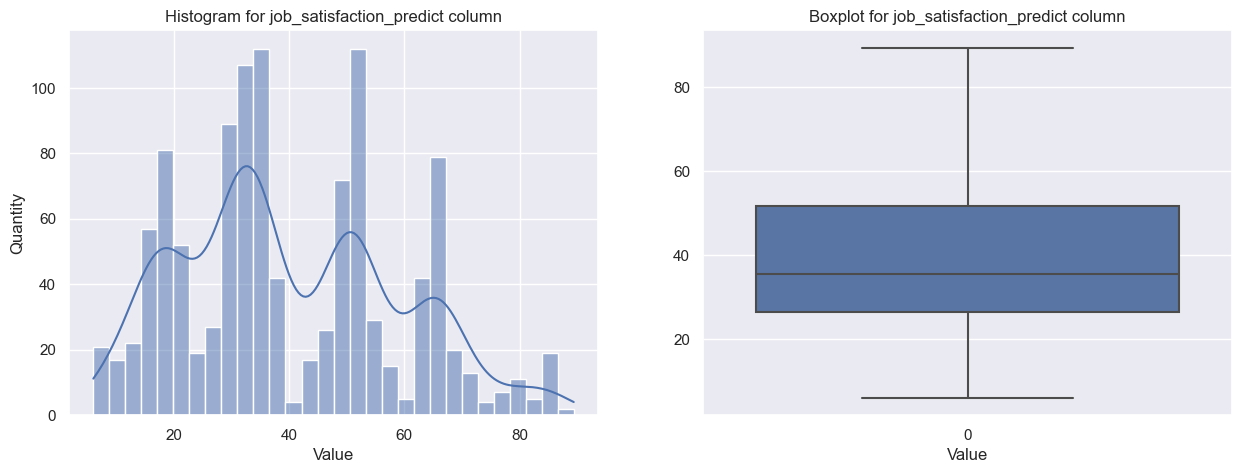

In [88]:
numerical_analysis(train_quit[train_quit['quit'] == 'yes'].reset_index(), 'job_satisfaction_predict')

On average, such employees have a satisfaction level of about 40, which is lower than if we consider this value for all employees (for all this value = 53)

So, an employee who decides to quit will most likely have the following data:
- Skill level: `junior`
- Load: `low` or `middle`
- Time worked in the bank in years: `up to 2 years`
- Promotion for the last year: `no`
- Rating from the manager: `3`
- Salary: `up to 28 thousand`
- Job satisfaction: `about 40`

#### Distribution of the job_satisfaction_rate attribute among employees

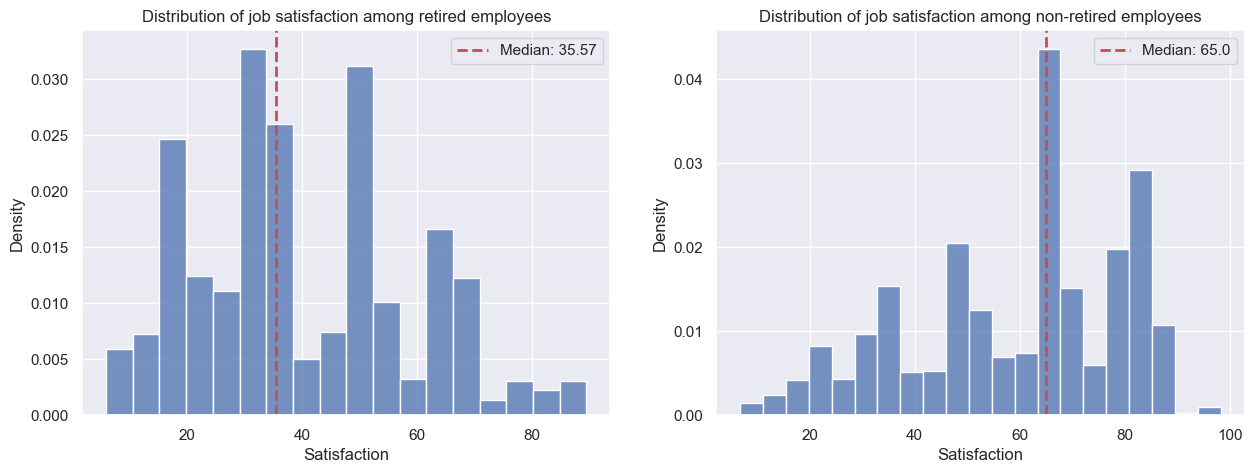

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Histogram for retired employees
ax[0] = sns.histplot(train_quit[train_quit['quit'] == 'yes']['job_satisfaction_predict'], ax=ax[0], stat='density')
ax[0].set_title('Distribution of job satisfaction among retired employees')
ax[0].set_xlabel('Satisfaction')
ax[0].set_ylabel('Density')

# Median line
median_yes = train_quit[train_quit['quit'] == 'yes']['job_satisfaction_predict'].median()
ax[0].axvline(median_yes, color='r', linestyle='dashed', linewidth=2, label=f'Median: {round(median_yes, 2)}')
ax[0].legend()

# Histogram for non-retired employees
ax[1] = sns.histplot(train_quit[train_quit['quit'] == 'no']['job_satisfaction_predict'], ax=ax[1], stat='density')
ax[1].set_title('Distribution of job satisfaction among non-retired employees')
ax[1].set_xlabel('Satisfaction')
ax[1].set_ylabel('Density')

# Median line
median_no = train_quit[train_quit['quit'] == 'no']['job_satisfaction_predict'].median()
ax[1].axvline(median_no, color='r', linestyle='dashed', linewidth=2, label=f'Median: {round(median_no, 2)}')
ax[1].legend()

Note that the median for quitting employees is noticeably lower than that for remaining employees, which partly confirms the theory that quitting is strongly influenced by the level of employee satisfaction.

### Correlation analysis

#### Correlation matrix

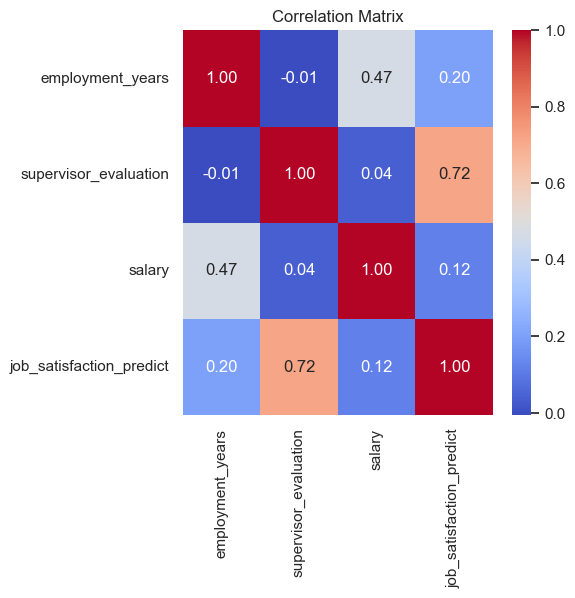

In [90]:
input_columns = train_quit.drop('id', axis=1).select_dtypes(exclude=['object']).columns.to_list()
correlation_matrix = train_quit[input_columns].corr() 

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Matrix')
plt.show()

Here, as in previous dataframes, there is a correlation between `job_satisfaction_predict` and `supervisor_evaluation`

Consider the correlation matrix using the `phik` library

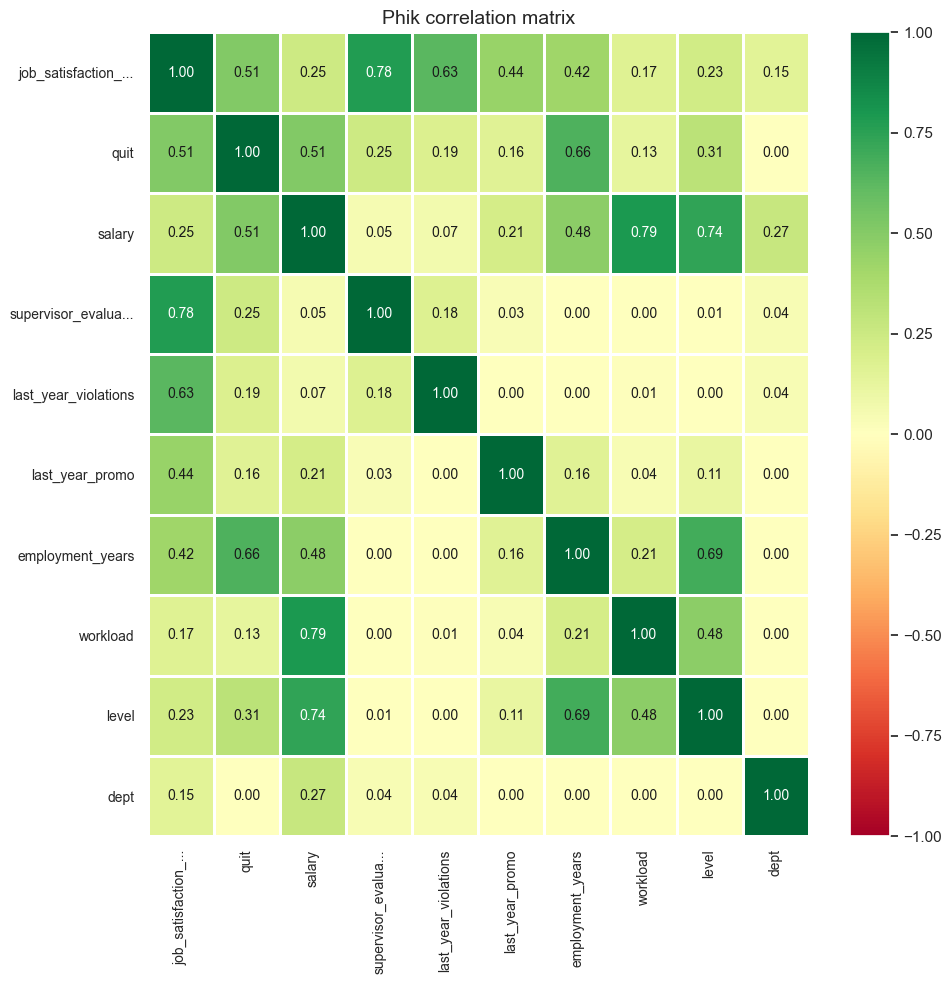

In [91]:
interval_cols = ['supervisor_evaluation', 'salary', 'employment_years', 'job_satisfaction_predict']

phik_overview = train_quit.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    title='Phik correlation matrix',
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(10, 10)
) 


There is a slight correlation here between `job_satisfaction_predict` and `quit`; `salary` and `quit`; `employment_years` and `quit`. There is also multicollinearity between other characteristics, but it is small, so it should not distort the work of the model.

#### Conclusions

- The target characteristic (`quit`) is most strongly influenced by the characteristics `employment_years`, `salary` and `job_satisfaction_predict`
- There are also logical dependencies between skill level and salary; workload and salary; work experience and skill level

### Data preparation

In [92]:
RANDOM_STATE = 42
target_column = 'quit'

train_quit.set_index('id', inplace=True)
test_target_quit.set_index('id', inplace=True)

See if duplicates have appeared and delete them if there are any.

In [93]:
print("Omissions in train-file before preprocessing:", train_quit.duplicated().sum())
train_quit = train_quit.drop_duplicates()
print("Omissions in train-file after preprocessing:", train_quit.duplicated().sum())


Omissions in train-file before preprocessing: 1413
Omissions in train-file after preprocessing: 0


In [94]:
ord_columns = ['level', 'workload']
ohe_columns = train_quit.drop([target_column, 'level', 'workload'], axis=1).select_dtypes(include=['object']).columns.to_list()
num_columns = train_quit.drop(target_column, axis=1).select_dtypes(exclude=['object']).columns.to_list()


test_data = pd.merge(test_features, test_target_quit, on='id')

X_train = train_quit.drop(target_column, axis=1)
y_train = train_quit[target_column]
X_test = test_data.drop(target_column, axis=1)
y_test = test_data[target_column]

Create a pipeline for data preparation

In [95]:
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
])



ord_pipe = Pipeline([
    ('SimpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high']
            ],
        handle_unknown='use_encoded_value', unknown_value=np.nan), 
        ),
    ('SimpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))

])


data_preprocessor = ColumnTransformer(
    [   
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

We should also encode the target feature. We use `LabelEncoder` for this

In [96]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Models

Since we are solving a binary classification problem, we should try models such as `LogisticRegression`; `KNeighborsClassifier`; `DecisionTreeClassifier`

ROC-AUC is a good metric for a binary classification problem, so we will choose it. Models with high ROC-AUC are better at separating classes and are therefore suitable for the task of predicting customer decline.

#### LogisticRegression

Create a final pipeline for the `LogisticRegression` model and sort out the hyperparameters for it

In [97]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1'))
])

params_grid = {
    'models__C': [0.1, 1, 5, 10],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
}

In [98]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    params_grid,
    n_jobs=-1,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE
)

randomized_search.fit(X_train, y_train)

print(f"Best model and it's parameters:\n{randomized_search.best_estimator_}")
print("Best model's score on cross-validation", randomized_search.best_score_)

Best model and it's parameters:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('SimpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                 

#### KNeighborsClassifier

Create a final pipeline for the `KNeighborsClassifier` model and sort out the hyperparameters for it

In [99]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

params_grid = {
    'models__n_neighbors': range(2, 6),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
}

In [100]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    params_grid,
    n_jobs=-1,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE
)

randomized_search.fit(X_train, y_train)

print(f"Best model and it's parameters:\n{randomized_search.best_estimator_}")
print("Best model's score on cross-validation", randomized_search.best_score_)

Best model and it's parameters:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('SimpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                 

#### DecisionTreeClassifier

Create a final pipeline for the `DecisionTreeClassifier` model and sort out the hyperparameters for it

In [101]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

params_grid = {
    'models__min_samples_split': range(2, 11),
    'models__min_samples_leaf': range(1, 11),
    'models__max_depth': (None, *range(2, 7)),
}

In [102]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    params_grid,
    n_jobs=-1,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE
)

randomized_search.fit(X_train, y_train)

print(f"Best model and it's parameters:\n{randomized_search.best_estimator_}")
print("Best model's score on cross-validation", randomized_search.best_score_)

Best model and it's parameters:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('SimpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                 

So, all models show good metrics. Let's try to use a decision tree for our business problem

In [103]:
print(randomized_search.best_params_)

{'models__min_samples_split': 6, 'models__min_samples_leaf': 7, 'models__max_depth': 5}


Let's look at how the model behaves on the test sample.

In [104]:
preprocessor= randomized_search.best_estimator_.named_steps['preprocessor']
best_model = randomized_search.best_estimator_.named_steps['models']

probabilities_one = randomized_search.predict_proba(X_test)[:, 1]
predictions = randomized_search.predict(X_test)

print('Accuracy:', accuracy_score(y_test, predictions))
print('Roc-Auc:', roc_auc_score(y_test, probabilities_one))
print('Precision:', precision_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))

Accuracy: 0.9
Roc-Auc: 0.9190095369327723
Precision: 0.792604501607717
Recall: 0.874113475177305


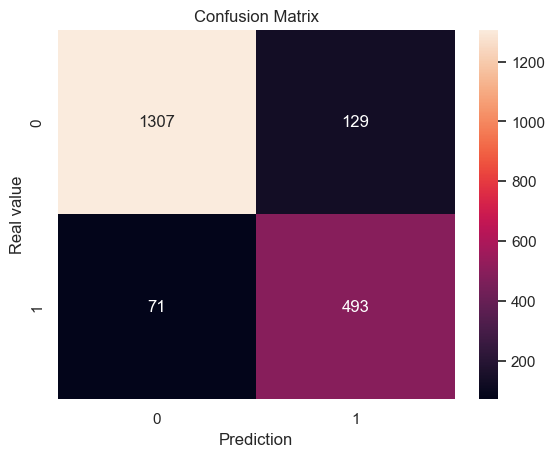

In [105]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt="d") 
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Real value');

- `True Negative` - 1307 true positive cases means that the model correctly classified 1307 objects as positive, and they actually belong to the positive class.

- `False Negative` - 129 false negative cases means that the model incorrectly classified 129 objects as negative, although they belong to the positive class.

- `False Positive` - 71 false positive cases means that the model incorrectly classified 71 objects as positive when they belonged to the negative class.

- `True Positive` - 493 true negative cases means that the model correctly classified 493 objects as negative, and they actually belong to the negative class.

1. **Accuracy**: 90% of all employees were correctly classified as "left" or "stayed" in the company.

2. **Roc-Auc (area under the ROC curve)**: This metric demonstrates that our models have a good ability to separate employees into two classes. The value of 0.919 indicates that the area under the ROC curve is close to 1, which is a sign of the model’s high-quality performance in identifying employees who plan to quit.

3. **Precision**: Precision estimates the proportion of employees that the model classified as quitters who actually quit. A value of 0.79 means that of all employees predicted to leave, 79% actually left.

4. **Recall (completeness)**: Recall estimates what percentage of quitting employees the model was able to identify. A value of 0.87 indicates that the model was able to detect 87% of all actual employee resignations.

In summary, the results indicate the high performance of the model, which can effectively separate employees into those who can leave and those who will stay.

In [106]:
# Assign the best model and it's preprocessor as the new variables
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
model = randomized_search.best_estimator_.named_steps['models']

# Get new names from the preprocessor
ohe_feature_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(input_features=ohe_columns)
ord_feature_names = preprocessor.named_transformers_['ord'].named_steps['ord'].get_feature_names_out(input_features=ord_columns)
num_feature_names = num_columns
names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

# Scale the features
X_train_scalled = pd.DataFrame(preprocessor.fit_transform(X_train), columns=names)
X_test_scalled =  pd.DataFrame(preprocessor.transform(X_test), columns=names)
model.fit(X_train_scalled, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=7, min_samples_split=6,
                       random_state=42)

Visualizing the tree using the `plot_tree()` method

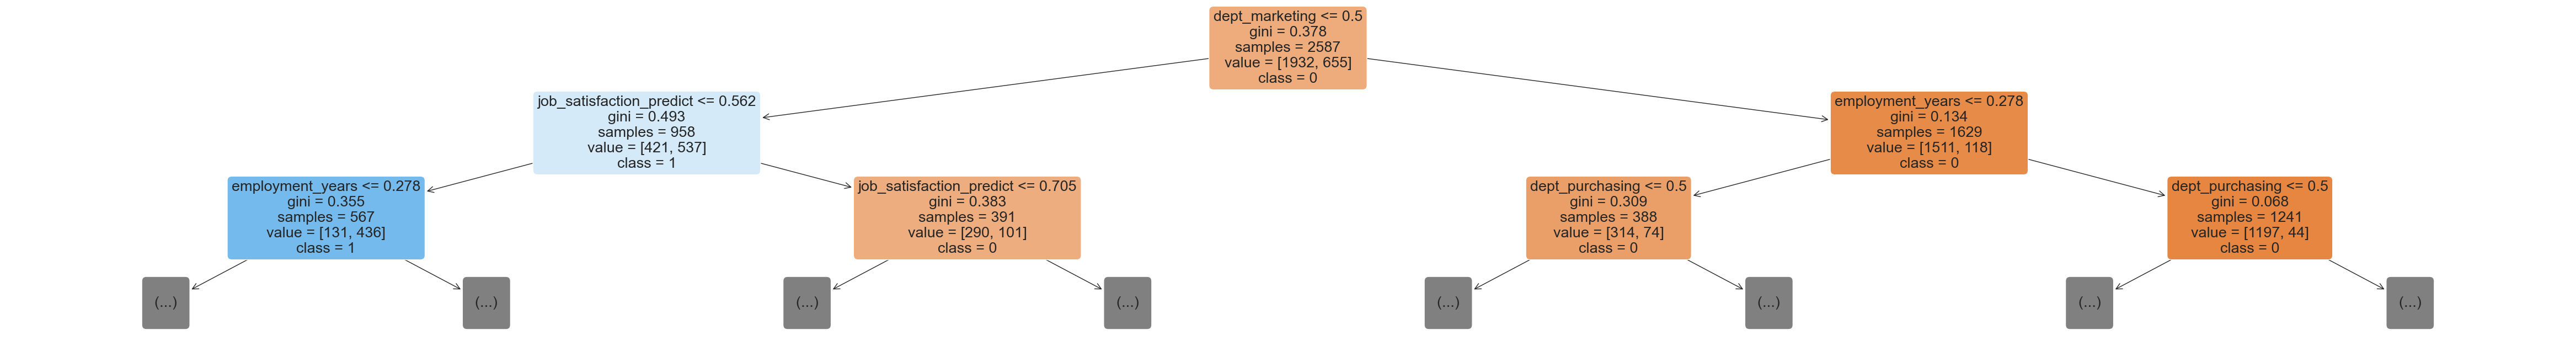

In [107]:
plt.figure(figsize=(60, 8)) 

class_names = [str(class_name) for class_name in model.classes_]
plot_tree(model, feature_names=names, max_depth=2, class_names=class_names, filled=True, rounded=True)
plt.show()


Take a look at the importance of signs

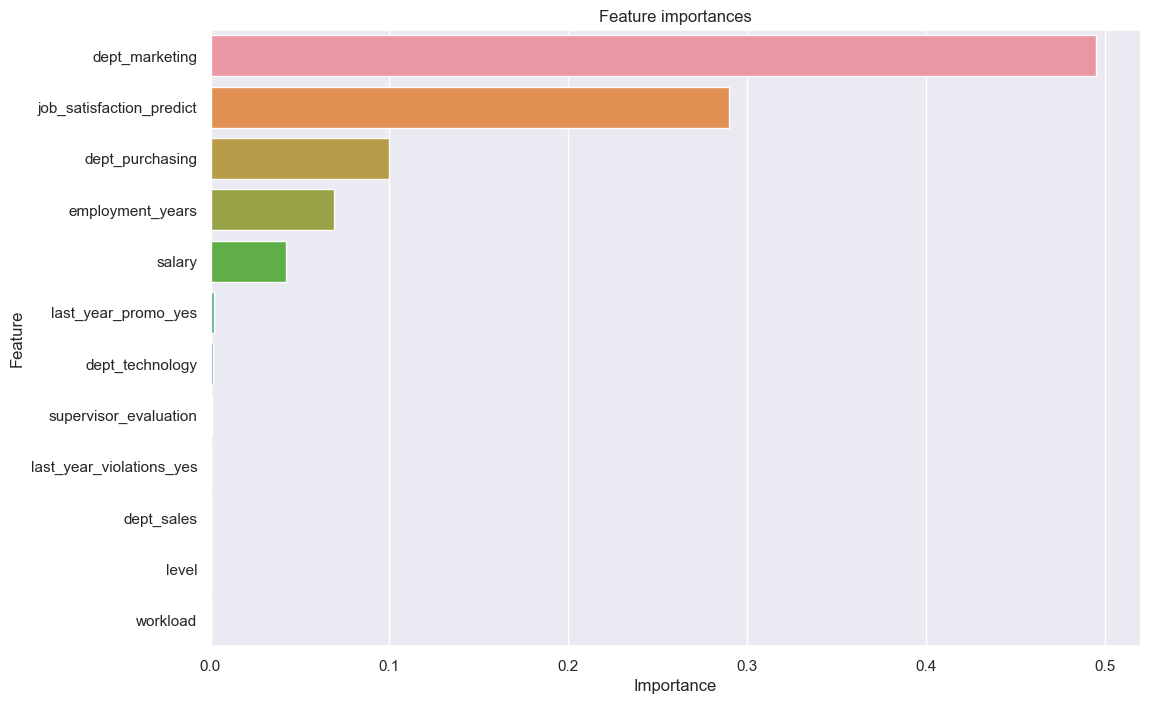

In [108]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature importances')
plt.show()

Note that the most important features for the model are `job_satisfaction_predict` and `dept_marketing`

Let's try to improve the model's metrics by discarding less important input features

In [109]:
accuracy1 = accuracy_score(y_test, predictions)
roc_auc_score1 = roc_auc_score(y_test, probabilities_one)

results = []

for i in range(1, len(X_test_scalled.columns) + 1):
    selector = SelectKBest(f_classif, k=i)
    selector.fit(X_train_scalled, y_train)
    
    features_names = X_train_scalled.columns[selector.get_support(indices=True)]
    
    X_train_new = X_train_scalled[list(features_names)]
    X_test_new = X_test_scalled[list(features_names)]

    model_new = model
    model_new.fit(X_train_new, y_train)

    predictions_new = model_new.predict(X_test_new)
    probabilities_new = model_new.predict_proba(X_test_new)[:, 1]

    accuracy_new = accuracy_score(y_test, predictions_new)
    roc_auc_score_new = roc_auc_score(y_test, probabilities_new)
    
    results.append({
        "num_features": i,
        "accuracy": accuracy_new,
        "roc_auc_score": roc_auc_score_new
    })

results_df = pd.DataFrame(results)

,num_features,accuracy,roc_auc_score
0,1,0.7190,0.763193
1,2,0.7455,0.816386
2,3,0.7495,0.837304
3,4,0.8900,0.915093
4,5,0.8900,0.915805
5,6,0.9010,0.921391
6,7,0.9010,0.921391
7,8,0.9010,0.921391
8,9,0.9010,0.921391
9,10,0.9000,0.919010


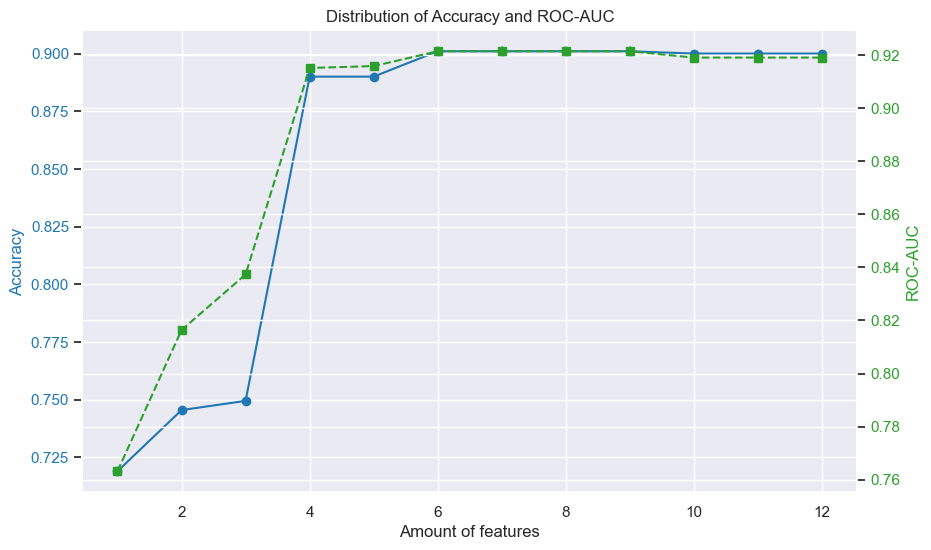

In [110]:
display(results_df)
num_features = results_df['num_features']
accuracy = results_df['accuracy']
roc_auc = results_df['roc_auc_score']

fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy graph
color = 'tab:blue'
ax1.set_xlabel('Amount of features')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(num_features, accuracy, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx() 

# Roc-Auc graph
color = 'tab:green'
ax2.set_ylabel('ROC-AUC', color='tab:green')
ax2.plot(num_features, roc_auc, marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Distribution of Accuracy and ROC-AUC')
plt.xlabel('Number of Features')

plt.grid(True)
plt.show()


The model will have the best performance if you use only the 6 best features.

In [111]:
selector = SelectKBest(f_classif, k=6)
selector.fit(X_train_scalled, y_train)

SelectKBest(k=6)

In [112]:
# Assign the best model and it's preprocessor as the new variables
preprocessor_cls = randomized_search.best_estimator_.named_steps['preprocessor']
model_cls = randomized_search.best_estimator_.named_steps['models']

# Get new names from the preprocessor
ohe_feature_names = preprocessor_cls.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(input_features=ohe_columns)
ord_feature_names = preprocessor_cls.named_transformers_['ord'].named_steps['ord'].get_feature_names_out(input_features=ord_columns)
num_feature_names = num_columns
names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

# Scale the features
X_train_scalled = pd.DataFrame(preprocessor_cls.fit_transform(X_train), columns=names)
X_test_scalled =  pd.DataFrame(preprocessor_cls.transform(X_test), columns=names)
model_cls.fit(X_train_scalled, y_train)

selected_features = selector.get_support(indices=True)
X_train_selected = X_train_scalled.iloc[:, selected_features]
X_test_selected = X_test_scalled.iloc[:, selected_features]

# Fitting the model with new train-data
model_cls.fit(X_train_selected, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=7, min_samples_split=6,
                       random_state=42)

Accuracy: 0.901
Roc-Auc: 0.9213906833402477
Precision: 0.7895569620253164
Recall: 0.8847517730496454


Text(47.25, 0.5, 'Real value')

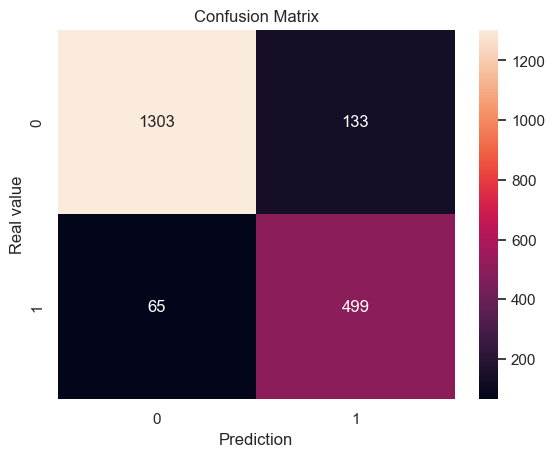

In [113]:
predictions = model_cls.predict(X_test_selected)
probabilities_one = model_cls.predict_proba(X_test_selected)[:,1]

print('Accuracy:', accuracy_score(y_test, predictions))
print('Roc-Auc:', roc_auc_score(y_test, probabilities_one))
print('Precision:', precision_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt="d") 
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Real value')

- `True Negative` - 1303 true positive cases means that the model correctly classified 1307 objects as positive, and they actually belong to the positive class.

- `False Negative` - 133 false negative cases means that the model incorrectly classified 129 objects as negative, although they belong to the positive class.

- `False Positive` - 65 false positive cases means that the model incorrectly classified 71 objects as positive when they belonged to the negative class.

- `True Positive` - 499 true negative cases means that the model correctly classified 493 objects as negative, and they actually belong to the negative class.

Our model now better identifies `True Positive` results and `False Positive` errors. It has become more accurate and has a `Roc-Auc` metric higher than before all the manipulations.

Let's see how the constant model copes with the task to make sure that the model fulfills the business task

In [114]:
X_train_scalled = data_preprocessor.fit_transform(X_train)
X_test_scalled = data_preprocessor.transform(X_test)

dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)

predictions_dummy = dummy.predict(X_test)
roc_auc_score(y_test, predictions_dummy)

0.5

Yes, our model does its job

In [115]:
test_features['quit_predict'] = predictions
test_features['probability'] = probabilities_one
test_features.info()
test_features.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dept                      1997 non-null   object 
 1   level                     1999 non-null   object 
 2   workload                  1999 non-null   object 
 3   employment_years          2000 non-null   int64  
 4   last_year_promo           2000 non-null   object 
 5   last_year_violations      2000 non-null   object 
 6   supervisor_evaluation     2000 non-null   int64  
 7   salary                    2000 non-null   int64  
 8   job_satisfaction_predict  2000 non-null   float64
 9   quit_predict              2000 non-null   int32  
 10  probability               2000 non-null   float64
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 179.7+ KB


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_predict,quit_predict,probability
id,,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,88.500000,0,0.203390
686555,hr,junior,medium,1,no,no,4,30000,67.875000,0,0.173469
467458,sales,middle,low,5,no,no,4,19200,64.333333,0,0.048387
418655,sales,middle,low,6,no,no,4,19200,66.600000,0,0.048387
789145,hr,middle,medium,5,no,no,5,40800,82.600000,0,0.014286
429973,purchasing,middle,medium,6,no,no,3,42000,66.285714,0,0.000000
850699,technology,junior,medium,3,no,no,3,26400,31.600000,1,0.885350
500791,sales,middle,high,9,no,no,4,49200,65.800000,0,0.045317
767867,marketing,middle,high,3,no,yes,4,62400,50.285714,0,0.031250


## General conclusion

### Description of tasks

- Task No. 1 - we needed to build a model that could predict the level of employee satisfaction based on customer data.
Why is this important for business: Job satisfaction directly affects employee churn. And predicting churn is one of the most important tasks of HR analysts. Sudden layoffs carry risks for the company, especially if an important employee leaves.
- Task No. 2 - we needed to build a model that could, based on customer data, predict that an employee would leave the company.

### Description of work stages

- Loaded all the necessary libraries and applied some settings

**Task 1**
- Downloaded the necessary files
- Conducted pre-processing for all files in order to begin further work
- Conducted correlation analysis for all characteristics to ensure that there is no strong multicollinearity in the data
- Created a pipeline for preparing data for training
- Trained the model by selecting the best hyperparameters for the model - the best model turned out to be `DecisionTreeRegressor` with parameters `models__min_samples_split`=5, `models__min_samples_leaf`=4, `models__max_features`=8, `models__max_depth`=None

(P.S. we had the task of selecting a model with the `SMAPE` <= 15 metric for test data. We achieved the figure 13.6)


**Task 2**
- Downloaded the necessary files
- Conducted pre-processing for all files in order to begin further work
- Added a new input feature `job_satisfaction_predict`, using the model from the previous task
- Conducted correlation analysis for all characteristics to ensure that there is no strong multicollinearity in the data
- Determined the porter of the “resigned employee”
- Created a pipeline for preparing data for training
- We selected and trained the best model with the best hyperparameters for it - the best model turned out to be `DecisionTreeClassifier` with parameters `max_depth`=5, `min_samples_leaf`=7, `min_samples_split`=6. It met the criterion `Roc-Auc` >= 0.91
- We slightly improved the model, achieving better results by changing the number of input features
- We identified the most important features for the model and visualized the decision-making branches (The most important features are `job_satisfaction_predict` and `dept_marketing`)

### Final conclusion

We completed all the customer’s tasks and managed to obtain the following models:

- The first is `best_model_dt` with the preprocessor `preprocessor_dt`: the model determines the level of employee satisfaction (on average, the model values differ by 13.9 percent from the real ones)

- Second - `model_cls` with the preprocessor `preprocessor_cls`: the model determines whether the employee will quit (the accuracy of the model is 90.1%)

Both models are quite accurate and can be used in business.